# Car Price Prediction Modeling

In [1]:
# Importing Dependencies
from sklearn.ensemble import VotingRegressor, StackingRegressor, AdaBoostRegressor, RandomForestRegressor, GradientBoostingRegressor
from turbo_utils import load_data, build_pipeline, visualize_predictions, evaluate_performance
from sklearn.preprocessing import RobustScaler, MinMaxScaler, MaxAbsScaler, StandardScaler
from sklearn.feature_selection import SelectFdr, SelectFwe, SelectFpr, f_regression
from sklearn.linear_model import BayesianRidge, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor
from sklearn.svm import SVR

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

import pandas as pd
import numpy as np
import warnings
import logging
import pickle
import shutil
import skopt
import yaml
import os

In [2]:
logging.basicConfig(filename = "../Logs/modeling.log", filemode = "w", format = "%(asctime)s - %(levelname)s - %(message)s", level = logging.INFO)
warnings.filterwarnings(action = "ignore")
pd.options.display.max_columns = None
np.random.seed(seed = 42)

Let's load the configuration file.

In [3]:
# Loading the configuration file
with open(file = "../Configuration/config.yml") as yaml_file:
    config = yaml.safe_load(stream = yaml_file)

Let's extract the evaluation metric.

In [4]:
# Extracting the evaluation metric
eval_metric = config.get("metric")

Let's call the function to load the dataset.

In [5]:
# Calling the function to load the dataset
df = load_data()

# Logging information to the logger file
logging.info(msg = "Input data has been loaded")

# Displaying the first five records
df.head()

,ID,vehicle_type,brand,model,year,engine,mileage,color,hp,fuel_type,speed_box,transmission,is_new,exchange_available,is_saloon_car,loan_available,functionalities,seller,contact_info,n_seen,last_updated_at,images,link,description,shop_location,google_maps_link,n_cars_by_shop,target
0,ID-6768428,Offroader/SUV,Hyundai,Venue,2022,1.6 L,0 km,Boz,123 a.g.,Benzin,Avtomat,Ön,Bəli,Barter mümkün deyil,Salon,Kreditde deyil,"['Yüngül lehimli disklər', 'ABS', 'Yağış senso...",Hyundai Gənclik,"['(050) 490-26-26', '(012) 564-08-22']",8141,2022-12-06,['https://turbo.azstatic.com/uploads/thumbnail...,https://turbo.az/autos/6768428-hyundai-venue,"""Hyundai Gənclik"" – Hyundai avtomobillərinin s...","Bakı ş., Nərimanov r., ak. Həsən Əliyev küç.",https://www.google.com/maps?q=40.401413%2C49.8...,8 elan,35900.0
1,ID-6720266,Offroader/SUV,Land Rover,Discovery,2016,3.0 L,125000 km,Boz,340 a.g.,Benzin,Avtomat,Tam,Xeyr,Barter mümkündür,Salon,Kreditde deyil,"['Yüngül lehimli disklər', 'ABS', 'Lyuk', 'Yağ...","Avtosalon ""Best Cars""","['(055) 737-03-03', '(055) 424-23-43', '(055) ...",3711,2022-12-04,['https://turbo.azstatic.com/uploads/thumbnail...,https://turbo.az/autos/6720266-land-rover-disc...,Fəlsəfəmiz adımızda əks olunub,"Bakı ş., Nizami r., Babək pr. 38A",https://www.google.com/maps?q=40.391307%2C49.9...,23 elan,71400.0
2,ID-6886015,Sedan,Honda,Insight,2020,1.5 L,78200 km,Göy,109 a.g.,Hibrid,Variator,Ön,Xeyr,Barter mümkün deyil,Salon,Kreditde deyil,"['Yüngül lehimli disklər', 'ABS', 'Yağış senso...","Avtosalon ""RR""","['(055) 885-38-88', '(050) 511-96-96', '(070) ...",1418,2022-12-06,['https://turbo.azstatic.com/uploads/thumbnail...,https://turbo.az/autos/6886015-honda-insight,"""RR"" avtosalonu avtomobillərin alqı-satqısı və...","Bakı ş., Heydər Əliyev pr., 108, ""Azpetrol"" YDM",https://www.google.com/maps?q=40.41837%2C49.91...,7 elan,37400.0
3,ID-6211658,Offroader/SUV,Bestune,T99,2022,2.0 L,0 km,Qara,225 a.g.,Benzin,Avtomat,Ön,Bəli,Barter mümkündür,Salon,Kreditde deyil,"['Yüngül lehimli disklər', 'ABS', 'Lyuk', 'Yağ...",Bestune Azərbaycan,"['(012) 310-07-85', '(055) 258-55-45']",148100,2022-12-01,['https://turbo.azstatic.com/uploads/thumbnail...,https://turbo.az/autos/6211658-bestune-t99,"""Bestune"" brendinin Azərbaycanda rəsmi distrib...","Bakı ş., Xətai r., Babək pr., 21/99 (Cahan Mot...",https://www.google.com/maps?q=40.390249%2C49.8...,11 elan,59900.0
4,ID-6771028,Offroader/SUV,Hyundai,ix35,2013,2.0 L,85000 km,Qara,166 a.g.,Benzin,Avtomat,Tam,Xeyr,Barter mümkün deyil,Şəxsi,Kreditde deyil,"['Yüngül lehimli disklər', 'ABS', 'Lyuk', 'Yağ...",Araz,(051) 311-21-32,3892,2022-11-10,['https://turbo.azstatic.com/uploads/thumbnail...,https://turbo.az/autos/6771028-hyundai-ix35,Salam.\n2mator.\nAvtomobil full kompletktasiya...,Şəxsi avtomobil satışlarında adres qeyd olunmur,Şəxsi avtomobil satışlarında Google Map üzərin...,Şəxsi avtomobil satışlarında satıcı tərəfindən...,28800.0


Let's create features and labels.

In [6]:
# Creating features
X = df.drop(columns = "target")

# Creating labels
y = df.target

# Splitting the features and labels into train & test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Displaying the shape
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((11235, 27), (11235,), (2809, 27), (2809,))

***
## Baseline

Let's call the function to a regressor pipeline.

In [7]:
# Calling the function to build a regressor pipeline
baseline_model = build_pipeline(regressor = DummyRegressor(),
                                train_features = X_train,
                                train_labels = y_train)

# Logging information to the logger file
logging.info(msg = "Baseline model has been trained")

# Displaying the architecture of the pipeline
baseline_model

Pipeline(steps=[('initial_preprocessor', InitialPreprocessor()),
                ('feature_transformer',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('nominal_pipeline',
                                                  Pipeline(steps=[('imputer',
                                                                   CustomImputer(strategy='most_frequent')),
                                                                  ('rle',
                                                                   RareLabelEncoder(n_categories=6)),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['vehicle_type', 'brand',
                                                   'origin', 'color',
                                                   'fu...
                                                   'has_leather_salon',
                                                   'has_xenon_lamps',
                                                   'has_rear_view_camera',
                                                   'has_side_curtains',
                                                   'has_seat_ventilation']),
                                                 ('numeric_pipeline',
                                                  Pipeline(steps=[('imputer',
                                                                   CustomImputer(strategy='median'))]),
                                                  ['age', 'engine', 'mileage',
                                                   'hp',
                                                   'avg_mileage_per_year'])])),
                ('constant_feature_dropper', ConstantDropper()),
                ('dtype_converter', DataTypeConverter()),
                ('regressor', DummyRegressor())])

Let's call the function to visualize the predictions of the regressor pipeline given the test features.

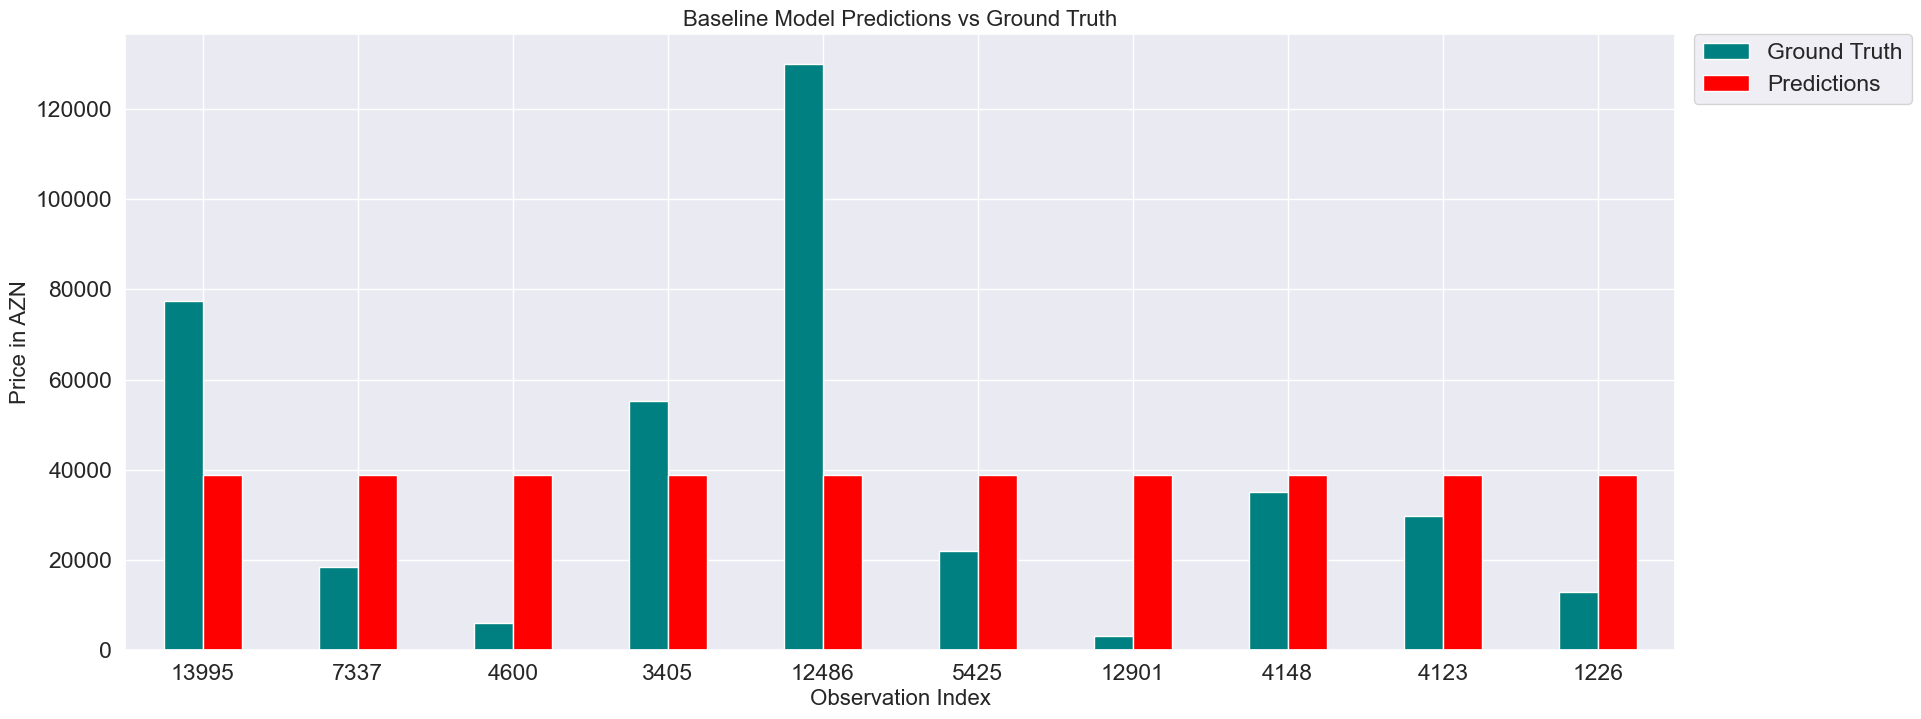

In [8]:
# Calling the function to visualize the predictions of the regressor pipeline given the test features
visualize_predictions(model = baseline_model, 
                      test_features = X_test,
                      test_labels = y_test, 
                      algorithm_name = "Baseline")

Let's call the function to evaluate the performance of the regressor pipeline.

In [9]:
# Calling the function to evaluate the performance of the regressor pipeline
baseline_model_summary_df = evaluate_performance(model = baseline_model,
                                                 train_features = X_train,
                                                 train_labels = y_train,
                                                 test_features = X_test,
                                                 test_labels = y_test,
                                                 algorithm_name = "Baseline")
# Displaying the evaluation summary
baseline_model_summary_df

,Train R2,Test R2,Train Adjusted R2,Test Adjusted R2,Train MAE,Test MAE,Train MAPE,Test MAPE,Train MSE,Test MSE,Train RMSE,Test RMSE,Mean CV,Max CV,Min CV,Std CV
Baseline,0.0,-0.0,-0.0,-0.01,31154.85,30417.17,1.74,1.81,2.768878e+09,2.781945e+09,52620.13,52744.15,0.0,0.0,0.0,0.0


***
## Linear Regression

Let's call the function to a regressor pipeline.

In [10]:
# Creating an operating level seed
np.random.seed(seed = 42)

# Creating a list of VIF thresholds
vif_thresholds = [2.5, 5, 10]

# Creating a list of capping methods
capping_methods = ["iqr", "gaussian", "percentile"]

# Creating a list of feature scaler instances
feature_scalers = [RobustScaler(), MinMaxScaler(), MaxAbsScaler(), StandardScaler()]

# Creating a list of statistical feature selector instances
statistical_feature_selectors = [SelectFpr(score_func = f_regression), SelectFdr(score_func = f_regression), SelectFwe(score_func = f_regression)]

# Creating a dictionary of hyperparameters
search_spaces = {}
search_spaces["regressor__feature_transformer__numeric_pipeline__vif_dropper__vif_threshold"] = skopt.space.Categorical(categories = vif_thresholds)
search_spaces["regressor__feature_transformer__numeric_pipeline__winsorizor__capping_method"] = skopt.space.Categorical(categories = capping_methods)
search_spaces["regressor__feature_transformer__numeric_pipeline__feature_scaler"] = skopt.space.Categorical(categories = feature_scalers)
search_spaces["regressor__feature_selector"] = skopt.space.Categorical(categories = statistical_feature_selectors)

# Calling the function to build a regressor pipeline
lr_model = build_pipeline(regressor = LinearRegression(),
                          train_features = X_train,
                          train_labels = y_train,
                          apply_log_transformation = True,
                          apply_phi_test = True,
                          drop_multicolliner_features = True, 
                          winsorize_outliers = True, 
                          apply_feature_scaling = True, 
                          feature_scaler_type = "robust", 
                          apply_feature_selection = True,
                          feature_selector_type = "p_value",
                          tune_hyperparameters = True,
                          hyperparameters = search_spaces,
                          n_iterations = 100,
                          verbosity = 1)

# Logging information to the logger file
logging.info(msg = "Linear Regression model has been trained")

# Displaying the architecture of the pipeline
lr_model

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=Pipeline(steps=[('initial_preprocessor',
                                                      InitialPreprocessor()),
                                                     ('feature_transformer',
                                                      ColumnTransformer(n_jobs=-1,
                                                                        transformers=[('nominal_pipeline',
                                                                                       Pipeline(steps=[('imputer',
                                                                                                        CustomImputer(strategy='most_frequent')),
                                                                                                       ('rle',
                                                                                                        RareLabelEncoder(n_categories=6)),
                                                                                                       ('ohe',
                                                                                                        OneHo...
                                                                                                        Winsorizor(capping_method='gaussian',
                                                                                                                   map_to_zero=True)),
                                                                                                       ('feature_scaler',
                                                                                                        StandardScaler())]),
                                                                                       ['age',
                                                                                        'engine',
                                                                                        'mileage',
                                                                                        'hp',
                                                                                        'avg_mileage_per_year'])])),
                                                     ('constant_feature_dropper',
                                                      ConstantDropper()),
                                                     ('dtype_converter',
                                                      DataTypeConverter()),
                                                     ('feature_selector',
                                                      SelectFdr(score_func=<function f_regression at 0x7fdc3a49a0d0>)),
                                                     ('regressor',
                                                      LinearRegression())]))

Let's call the function to visualize the predictions of the regressor pipeline given the test features.

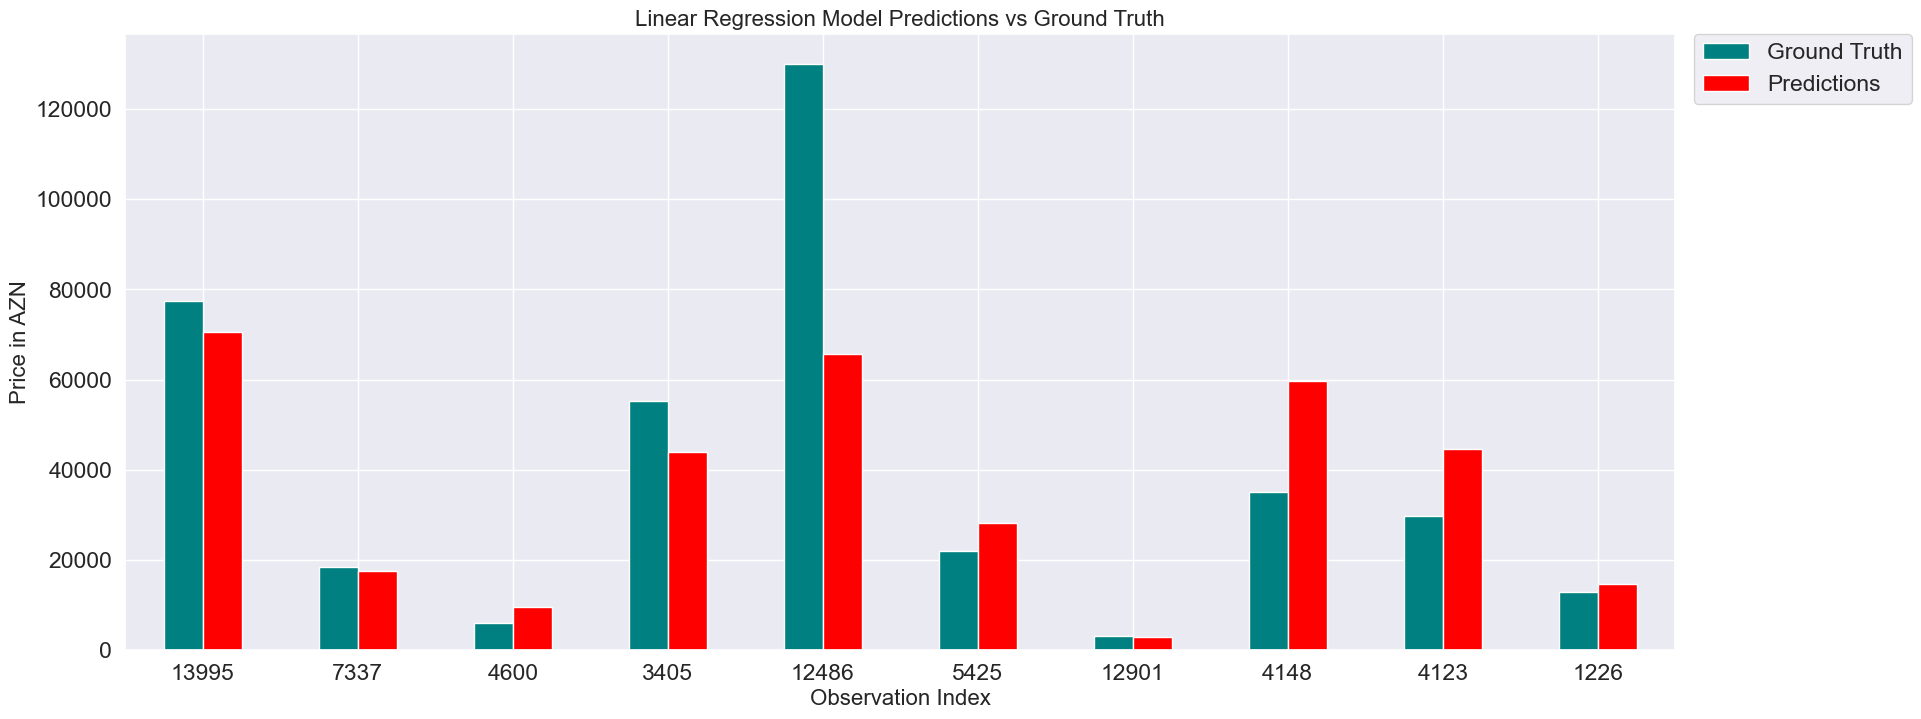

In [11]:
# Calling the function to visualize the predictions of the regressor pipeline given the test features
visualize_predictions(model = lr_model, 
                      test_features = X_test,
                      test_labels = y_test, 
                      algorithm_name = "Linear Regression")

Let's call the function to evaluate the performance of the regressor pipeline.

In [12]:
# Calling the function to evaluate the performance of the regressor pipeline
lr_model_summary_df = evaluate_performance(model = lr_model,
                                           train_features = X_train,
                                           train_labels = y_train,
                                           test_features = X_test,
                                           test_labels = y_test,
                                           algorithm_name = "Linear Regression")
# Displaying the evaluation summary
lr_model_summary_df

,Train R2,Test R2,Train Adjusted R2,Test Adjusted R2,Train MAE,Test MAE,Train MAPE,Test MAPE,Train MSE,Test MSE,Train RMSE,Test RMSE,Mean CV,Max CV,Min CV,Std CV
Linear Regression,0.77,0.73,0.77,0.73,9880.98,9814.49,0.23,0.23,6.293385e+08,748531122.1,25086.62,27359.3,0.77,0.8,0.76,0.01


***
## Bayesian Ridge

Let's call the function to a regressor pipeline.

In [13]:
# Creating an operating level seed
np.random.seed(seed = 42)

# Creating a dictionary of hyperparameters
search_spaces = {}
search_spaces["regressor__feature_transformer__numeric_pipeline__vif_dropper__vif_threshold"] = skopt.space.Categorical(categories = vif_thresholds)
search_spaces["regressor__feature_transformer__numeric_pipeline__winsorizor__capping_method"] = skopt.space.Categorical(categories = capping_methods)
search_spaces["regressor__feature_transformer__numeric_pipeline__feature_scaler"] = skopt.space.Categorical(categories = feature_scalers)
search_spaces["regressor__feature_selector__percentile"] = skopt.space.Categorical(categories = list(range(10, 101, 10)))
search_spaces["regressor__regressor__tol"] = skopt.space.Real(low = 1e-6, high = 0.1, prior = "log-uniform")
search_spaces["regressor__regressor__alpha_1"] = skopt.space.Real(low = 1e-6, high = 0.1, prior = "log-uniform")
search_spaces["regressor__regressor__alpha_2"] = skopt.space.Real(low = 1e-6, high = 0.1, prior = "log-uniform")
search_spaces["regressor__regressor__lambda_1"] = skopt.space.Real(low = 1e-6, high = 0.1, prior = "log-uniform")
search_spaces["regressor__regressor__lambda_2"] = skopt.space.Real(low = 1e-6, high = 0.1, prior = "log-uniform")

# Calling the function to build a regressor pipeline
br_model = build_pipeline(regressor = BayesianRidge(),
                          train_features = X_train,
                          train_labels = y_train, 
                          apply_log_transformation = True,
                          apply_phi_test = True,
                          drop_multicolliner_features = True, 
                          winsorize_outliers = True, 
                          apply_feature_scaling = True, 
                          feature_scaler_type = "minmax", 
                          apply_feature_selection = True,
                          feature_selector_type = "univariate", 
                          tune_hyperparameters = True,
                          hyperparameters = search_spaces,
                          n_iterations = 100,
                          verbosity = 1)

# Logging information to the logger file
logging.info(msg = "Bayesian Ridge model has been trained")

# Displaying the architecture of the pipeline
br_model

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=Pipeline(steps=[('initial_preprocessor',
                                                      InitialPreprocessor()),
                                                     ('feature_transformer',
                                                      ColumnTransformer(n_jobs=-1,
                                                                        transformers=[('nominal_pipeline',
                                                                                       Pipeline(steps=[('imputer',
                                                                                                        CustomImputer(strategy='most_frequent')),
                                                                                                       ('rle',
                                                                                                        RareLabelEncoder(n_categories=6)),
                                                                                                       ('ohe',
                                                                                                        OneHo...
                                                                                                        Winsorizor(capping_method='gaussian',
                                                                                                                   map_to_zero=True)),
                                                                                                       ('feature_scaler',
                                                                                                        RobustScaler())]),
                                                                                       ['age',
                                                                                        'engine',
                                                                                        'mileage',
                                                                                        'hp',
                                                                                        'avg_mileage_per_year'])])),
                                                     ('constant_feature_dropper',
                                                      ConstantDropper()),
                                                     ('dtype_converter',
                                                      DataTypeConverter()),
                                                     ('feature_selector',
                                                      SelectPercentile(percentile=100)),
                                                     ('regressor',
                                                      BayesianRidge(alpha_1=0.1,
                                                                    lambda_2=0.1,
                                                                    tol=1e-06))]))

Let's call the function to visualize the predictions of the regressor pipeline given the test features.

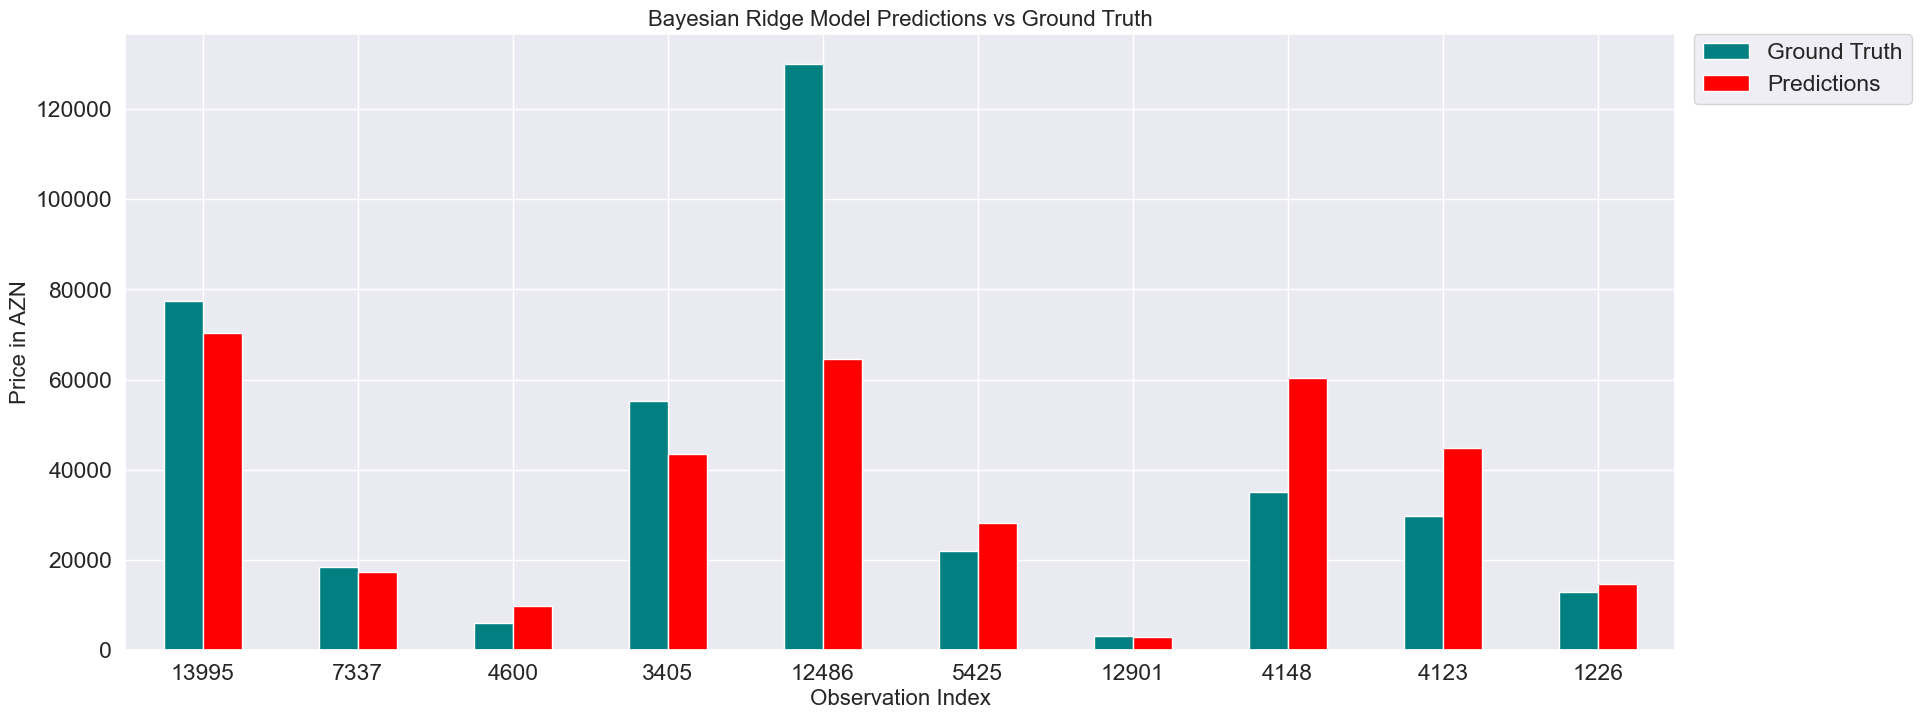

In [14]:
# Calling the function to visualize the predictions of the regressor pipeline given the test features
visualize_predictions(model = br_model, 
                      test_features = X_test,
                      test_labels = y_test, 
                      algorithm_name = "Bayesian Ridge")

Let's call the function to evaluate the performance of the regressor pipeline.

In [15]:
# Calling the function to evaluate the performance of the regressor pipeline
br_model_summary_df = evaluate_performance(model = br_model,
                                           train_features = X_train,
                                           train_labels = y_train,
                                           test_features = X_test,
                                           test_labels = y_test,
                                           algorithm_name = "Bayesian Ridge")
# Displaying the evaluation summary
br_model_summary_df

,Train R2,Test R2,Train Adjusted R2,Test Adjusted R2,Train MAE,Test MAE,Train MAPE,Test MAPE,Train MSE,Test MSE,Train RMSE,Test RMSE,Mean CV,Max CV,Min CV,Std CV
Bayesian Ridge,0.77,0.73,0.77,0.73,9896.55,9837.58,0.23,0.23,6.350762e+08,7.565509e+08,25200.72,27505.47,0.77,0.79,0.75,0.01


***
## Support Vector Machine

Let's call the function to a regressor pipeline.

In [16]:
# Creating an operating level seed
np.random.seed(seed = 42)

# Creating a dictionary of hyperparameters
search_spaces = {}
search_spaces["regressor__feature_transformer__numeric_pipeline__feature_scaler"] = skopt.space.Categorical(categories = feature_scalers)
search_spaces["regressor__feature_selector__percentile"] = skopt.space.Categorical(categories = list(range(10, 101, 10)))
search_spaces["regressor__regressor__kernel"] = skopt.space.Categorical(categories = ["rbf", "linear"])
search_spaces["regressor__regressor__tol"] = skopt.space.Real(low = 1e-6, high = 0.1, prior = "log-uniform")
search_spaces["regressor__regressor__C"] = skopt.space.Real(low = 1e-6, high = 1.0, prior = "log-uniform")

# Calling the function to build a regressor pipeline
svm_model = build_pipeline(regressor = SVR(),
                           train_features = X_train,
                           train_labels = y_train, 
                           apply_log_transformation = True,
                           apply_feature_scaling = True, 
                           feature_scaler_type = "maxabs", 
                           apply_feature_selection = True,
                           feature_selector_type = "univariate", 
                           tune_hyperparameters = True,
                           hyperparameters = search_spaces,
                           n_iterations = 100,
                           verbosity = 1)

# Logging information to the logger file
logging.info(msg = "Support Vector Machine model has been trained")

# Displaying the architecture of the pipeline
svm_model

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=Pipeline(steps=[('initial_preprocessor',
                                                      InitialPreprocessor()),
                                                     ('feature_transformer',
                                                      ColumnTransformer(n_jobs=-1,
                                                                        transformers=[('nominal_pipeline',
                                                                                       Pipeline(steps=[('imputer',
                                                                                                        CustomImputer(strategy='most_frequent')),
                                                                                                       ('rle',
                                                                                                        RareLabelEncoder(n_categories=6)),
                                                                                                       ('ohe',
                                                                                                        OneHo...
                                                                                      ('numeric_pipeline',
                                                                                       Pipeline(steps=[('imputer',
                                                                                                        CustomImputer(strategy='median')),
                                                                                                       ('feature_scaler',
                                                                                                        StandardScaler())]),
                                                                                       ['age',
                                                                                        'engine',
                                                                                        'mileage',
                                                                                        'hp',
                                                                                        'avg_mileage_per_year'])])),
                                                     ('constant_feature_dropper',
                                                      ConstantDropper()),
                                                     ('dtype_converter',
                                                      DataTypeConverter()),
                                                     ('feature_selector',
                                                      SelectPercentile(percentile=100)),
                                                     ('regressor',
                                                      SVR(tol=1e-06))]))

Let's call the function to visualize the predictions of the regressor pipeline given the test features.

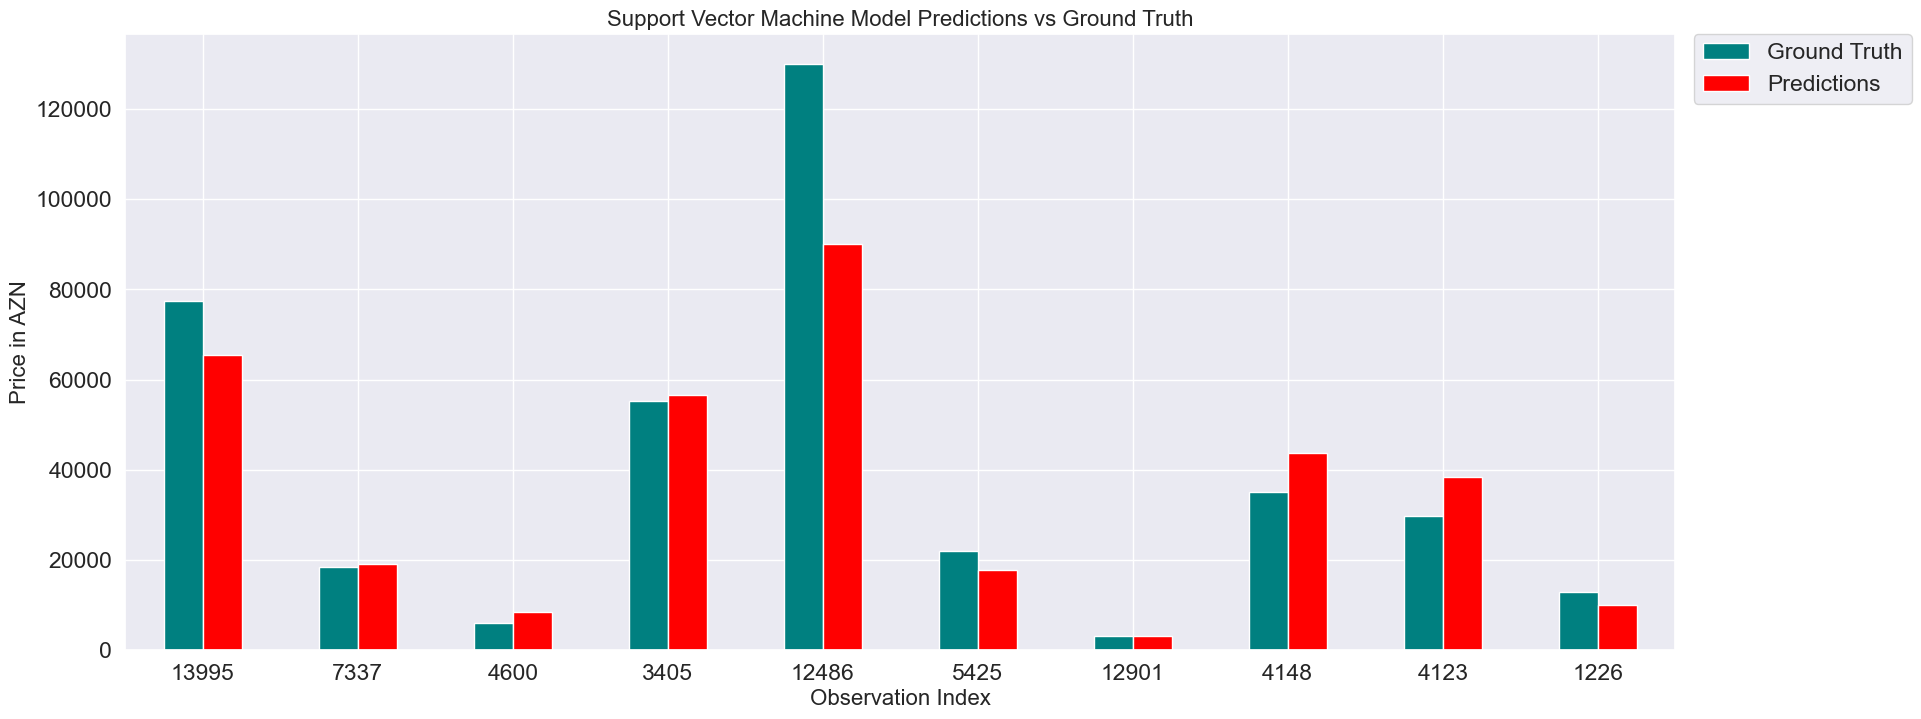

In [17]:
# Calling the function to visualize the predictions of the regressor pipeline given the test features
visualize_predictions(model = svm_model, 
                      test_features = X_test,
                      test_labels = y_test, 
                      algorithm_name = "Support Vector Machine")

Let's call the function to evaluate the performance of the regressor pipeline.

In [18]:
# Calling the function to evaluate the performance of the regressor pipeline
svm_model_summary_df = evaluate_performance(model = svm_model,
                                            train_features = X_train,
                                            train_labels = y_train,
                                            test_features = X_test,
                                            test_labels = y_test,
                                            algorithm_name = "Support Vector Machine")
# Displaying the evaluation summary
svm_model_summary_df

,Train R2,Test R2,Train Adjusted R2,Test Adjusted R2,Train MAE,Test MAE,Train MAPE,Test MAPE,Train MSE,Test MSE,Train RMSE,Test RMSE,Mean CV,Max CV,Min CV,Std CV
Support Vector Machine,0.94,0.89,0.94,0.89,4899.62,5653.77,0.12,0.15,1.602209e+08,3.054998e+08,12657.84,17478.55,0.91,0.93,0.89,0.02


***
## K Nearest Neighbors

Let's call the function to a regressor pipeline.

In [19]:
# Creating an operating level seed
np.random.seed(seed = 42)

# Creating a dictionary of hyperparameters
search_spaces = {}
search_spaces["regressor__feature_transformer__numeric_pipeline__feature_scaler"] = skopt.space.Categorical(categories = feature_scalers)
search_spaces["regressor__feature_selector__percentile"] = skopt.space.Categorical(categories = list(range(10, 101, 10)))
search_spaces["regressor__regressor__n_neighbors"] = skopt.space.Integer(low = 2, high = 6)
search_spaces["regressor__regressor__weights"] = skopt.space.Categorical(categories = ["uniform", "distance"])

# Calling the function to build a regressor pipeline
knn_model = build_pipeline(regressor = KNeighborsRegressor(n_jobs = -1),
                           train_features = X_train,
                           train_labels = y_train, 
                           apply_log_transformation = True,
                           apply_feature_scaling = True, 
                           feature_scaler_type = "standard", 
                           apply_feature_selection = True,
                           feature_selector_type = "univariate", 
                           tune_hyperparameters = True,
                           hyperparameters = search_spaces,
                           n_iterations = 100,
                           verbosity = 1)

# Logging information to the logger file
logging.info(msg = "K Nearest Neighbors model has been trained")

# Displaying the architecture of the pipeline
knn_model

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=Pipeline(steps=[('initial_preprocessor',
                                                      InitialPreprocessor()),
                                                     ('feature_transformer',
                                                      ColumnTransformer(n_jobs=-1,
                                                                        transformers=[('nominal_pipeline',
                                                                                       Pipeline(steps=[('imputer',
                                                                                                        CustomImputer(strategy='most_frequent')),
                                                                                                       ('rle',
                                                                                                        RareLabelEncoder(n_categories=6)),
                                                                                                       ('ohe',
                                                                                                        OneHo...
                                                                                                        CustomImputer(strategy='median')),
                                                                                                       ('feature_scaler',
                                                                                                        StandardScaler())]),
                                                                                       ['age',
                                                                                        'engine',
                                                                                        'mileage',
                                                                                        'hp',
                                                                                        'avg_mileage_per_year'])])),
                                                     ('constant_feature_dropper',
                                                      ConstantDropper()),
                                                     ('dtype_converter',
                                                      DataTypeConverter()),
                                                     ('feature_selector',
                                                      SelectPercentile(percentile=80)),
                                                     ('regressor',
                                                      KNeighborsRegressor(n_jobs=-1,
                                                                          n_neighbors=4,
                                                                          weights='distance'))]))

Let's call the function to visualize the predictions of the regressor pipeline given the test features.

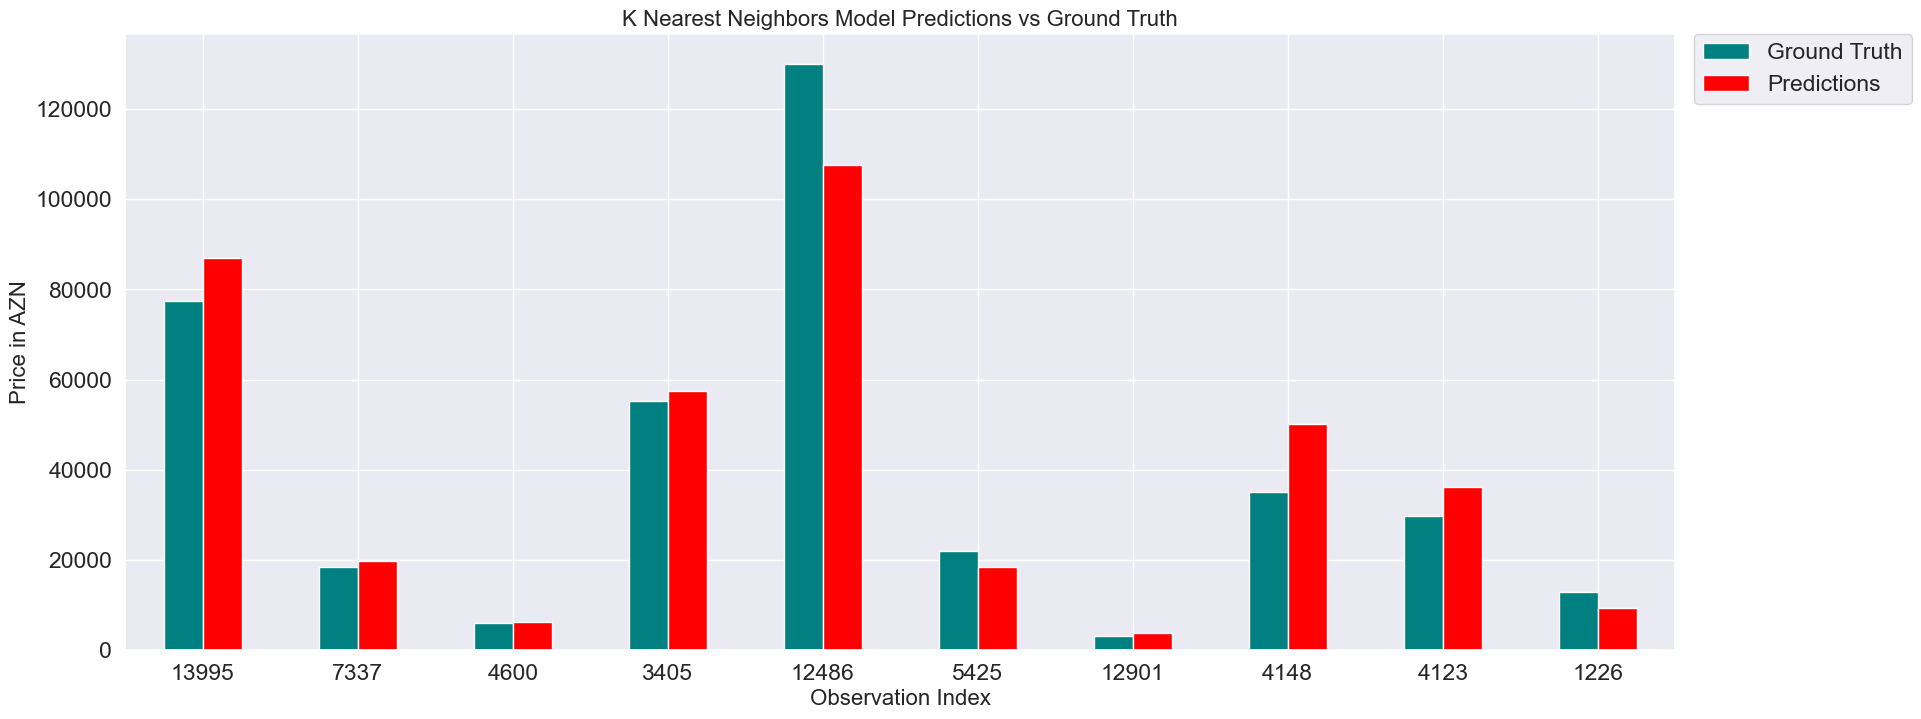

In [20]:
# Calling the function to visualize the predictions of the regressor pipeline given the test features
visualize_predictions(model = knn_model, 
                      test_features = X_test,
                      test_labels = y_test, 
                      algorithm_name = "K Nearest Neighbors")

Let's call the function to evaluate the performance of the regressor pipeline.

In [21]:
# Calling the function to evaluate the performance of the regressor pipeline
knn_model_summary_df = evaluate_performance(model = knn_model,
                                            train_features = X_train,
                                            train_labels = y_train,
                                            test_features = X_test,
                                            test_labels = y_test,
                                            algorithm_name = "K Nearest Neighbors")
# Displaying the evaluation summary
knn_model_summary_df

,Train R2,Test R2,Train Adjusted R2,Test Adjusted R2,Train MAE,Test MAE,Train MAPE,Test MAPE,Train MSE,Test MSE,Train RMSE,Test RMSE,Mean CV,Max CV,Min CV,Std CV
K Nearest Neighbors,1.0,0.86,1.0,0.86,126.83,6936.96,0.0,0.2,3700273.7,3.968477e+08,1923.61,19921.04,0.88,0.91,0.85,0.02


***
## Multi Layer Perceptron

Let's call the function to a regressor pipeline.

In [22]:
# Creating an operating level seed
np.random.seed(seed = 42)

# Creating a dictionary of hyperparameters
search_spaces = {}
search_spaces["regressor__feature_transformer__numeric_pipeline__feature_scaler"] = skopt.space.Categorical(categories = feature_scalers)
search_spaces["regressor__feature_selector__percentile"] = skopt.space.Categorical(categories = list(range(10, 101, 10)))
search_spaces["regressor__regressor__alpha"] = skopt.space.Real(low = 1e-6, high = 0.1, prior = "log-uniform")
search_spaces["regressor__regressor__tol"] = skopt.space.Real(low = 1e-6, high = 0.1, prior = "log-uniform")
search_spaces["regressor__regressor__n_iter_no_change"] = skopt.space.Categorical(categories = [3, 5, 7])

# Calling the function to build a regressor pipeline
mlp_model = build_pipeline(regressor = MLPRegressor(learning_rate = "adaptive", 
                                                    max_iter = 1000, 
                                                    random_state = 42, 
                                                    early_stopping = True, 
                                                    n_iter_no_change = 3),
                           train_features = X_train,
                           train_labels = y_train, 
                           apply_log_transformation = True,
                           apply_feature_scaling = True, 
                           feature_scaler_type = "standard", 
                           apply_feature_selection = True,
                           feature_selector_type = "univariate", 
                           tune_hyperparameters = True,
                           hyperparameters = search_spaces,
                           n_iterations = 100,
                           verbosity = 1)

# Logging information to the logger file
logging.info(msg = "Multi Layer Perceptron model has been trained")

# Displaying the architecture of the pipeline
mlp_model

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=Pipeline(steps=[('initial_preprocessor',
                                                      InitialPreprocessor()),
                                                     ('feature_transformer',
                                                      ColumnTransformer(n_jobs=-1,
                                                                        transformers=[('nominal_pipeline',
                                                                                       Pipeline(steps=[('imputer',
                                                                                                        CustomImputer(strategy='most_frequent')),
                                                                                                       ('rle',
                                                                                                        RareLabelEncoder(n_categories=6)),
                                                                                                       ('ohe',
                                                                                                        OneHo...
                                                                                        'hp',
                                                                                        'avg_mileage_per_year'])])),
                                                     ('constant_feature_dropper',
                                                      ConstantDropper()),
                                                     ('dtype_converter',
                                                      DataTypeConverter()),
                                                     ('feature_selector',
                                                      SelectPercentile(percentile=50)),
                                                     ('regressor',
                                                      MLPRegressor(alpha=0.0002817064175979141,
                                                                   early_stopping=True,
                                                                   learning_rate='adaptive',
                                                                   max_iter=1000,
                                                                   n_iter_no_change=5,
                                                                   random_state=42,
                                                                   tol=7.221099389295074e-05))]))

Let's call the function to visualize the predictions of the regressor pipeline given the test features.

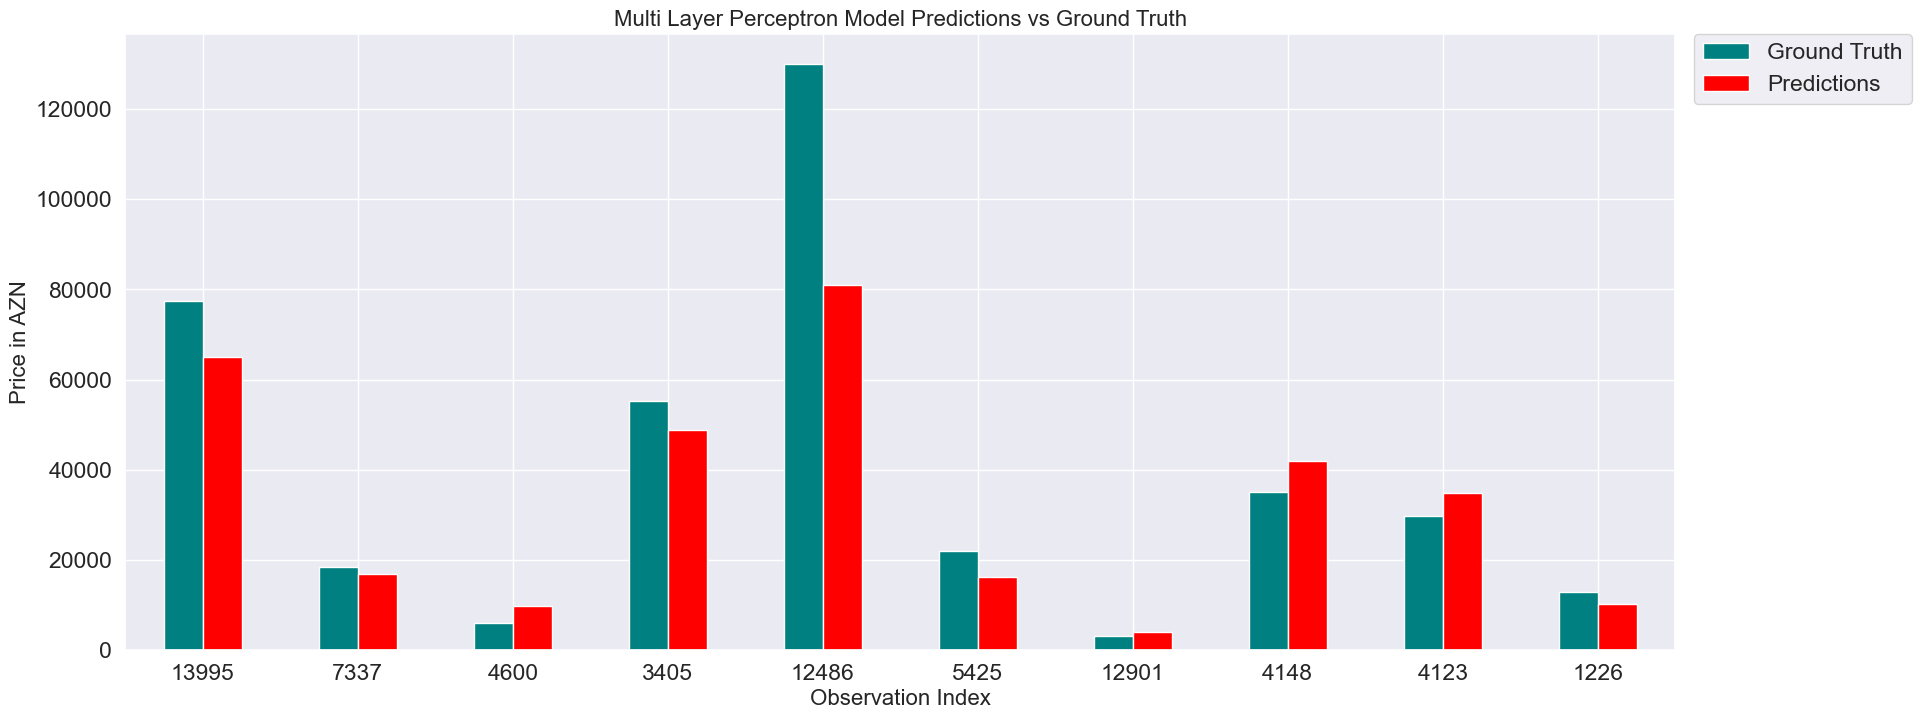

In [23]:
# Calling the function to visualize the predictions of the regressor pipeline given the test features
visualize_predictions(model = mlp_model, 
                      test_features = X_test,
                      test_labels = y_test, 
                      algorithm_name = "Multi Layer Perceptron")

Let's call the function to evaluate the performance of the regressor pipeline.

In [24]:
# Calling the function to evaluate the performance of the regressor pipeline
mlp_model_summary_df = evaluate_performance(model = mlp_model,
                                            train_features = X_train,
                                            train_labels = y_train,
                                            test_features = X_test,
                                            test_labels = y_test,
                                            algorithm_name = "Multi Layer Perceptron")
# Displaying the evaluation summary
mlp_model_summary_df

,Train R2,Test R2,Train Adjusted R2,Test Adjusted R2,Train MAE,Test MAE,Train MAPE,Test MAPE,Train MSE,Test MSE,Train RMSE,Test RMSE,Mean CV,Max CV,Min CV,Std CV
Multi Layer Perceptron,0.88,0.85,0.88,0.85,7682.45,7699.03,0.2,0.21,3.225830e+08,4.260789e+08,17960.59,20641.68,22.06,106.82,0.85,42.38


***
## Decision Tree

Let's call the function to a regressor pipeline.

In [25]:
# Creating an operating level seed
np.random.seed(seed = 42)

# Creating a dictionary of hyperparameters
search_spaces = {}
search_spaces["feature_selector__threshold"] = skopt.space.Categorical(categories = [None, "median"])
search_spaces["regressor__max_depth"] = skopt.space.Integer(low = 2, high = 6)
search_spaces["regressor__min_samples_split"] = skopt.space.Integer(low = 2, high = 6)
search_spaces["regressor__min_samples_leaf"] = skopt.space.Integer(low = 1, high = 6)
search_spaces["regressor__max_features"] = skopt.space.Categorical(categories = ["auto", "sqrt", "log2"])

# Calling the function to build a regressor pipeline
dt_model = build_pipeline(regressor = DecisionTreeRegressor(random_state = 42),
                          train_features = X_train,
                          train_labels = y_train, 
                          apply_feature_selection = True,
                          feature_selector_type = "meta", 
                          tune_hyperparameters = True,
                          hyperparameters = search_spaces,
                          n_iterations = 100,
                          verbosity = 1)

# Logging information to the logger file
logging.info(msg = "Decision Tree model has been trained")

# Displaying the architecture of the pipeline
dt_model

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

Pipeline(steps=[('initial_preprocessor', InitialPreprocessor()),
                ('feature_transformer',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('nominal_pipeline',
                                                  Pipeline(steps=[('imputer',
                                                                   CustomImputer(strategy='most_frequent')),
                                                                  ('rle',
                                                                   RareLabelEncoder(n_categories=6)),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['vehicle_type', 'brand',
                                                   'origin', 'color',
                                                   'fu...
                                                                   CustomImputer(strategy='median'))]),
                                                  ['age', 'engine', 'mileage',
                                                   'hp',
                                                   'avg_mileage_per_year'])])),
                ('constant_feature_dropper', ConstantDropper()),
                ('dtype_converter', DataTypeConverter()),
                ('feature_selector',
                 SelectFromModel(estimator=DecisionTreeRegressor(random_state=42))),
                ('regressor',
                 DecisionTreeRegressor(max_depth=6, max_features='auto',
                                       min_samples_split=6, random_state=42))])

Let's call the function to visualize the predictions of the regressor pipeline given the test features.

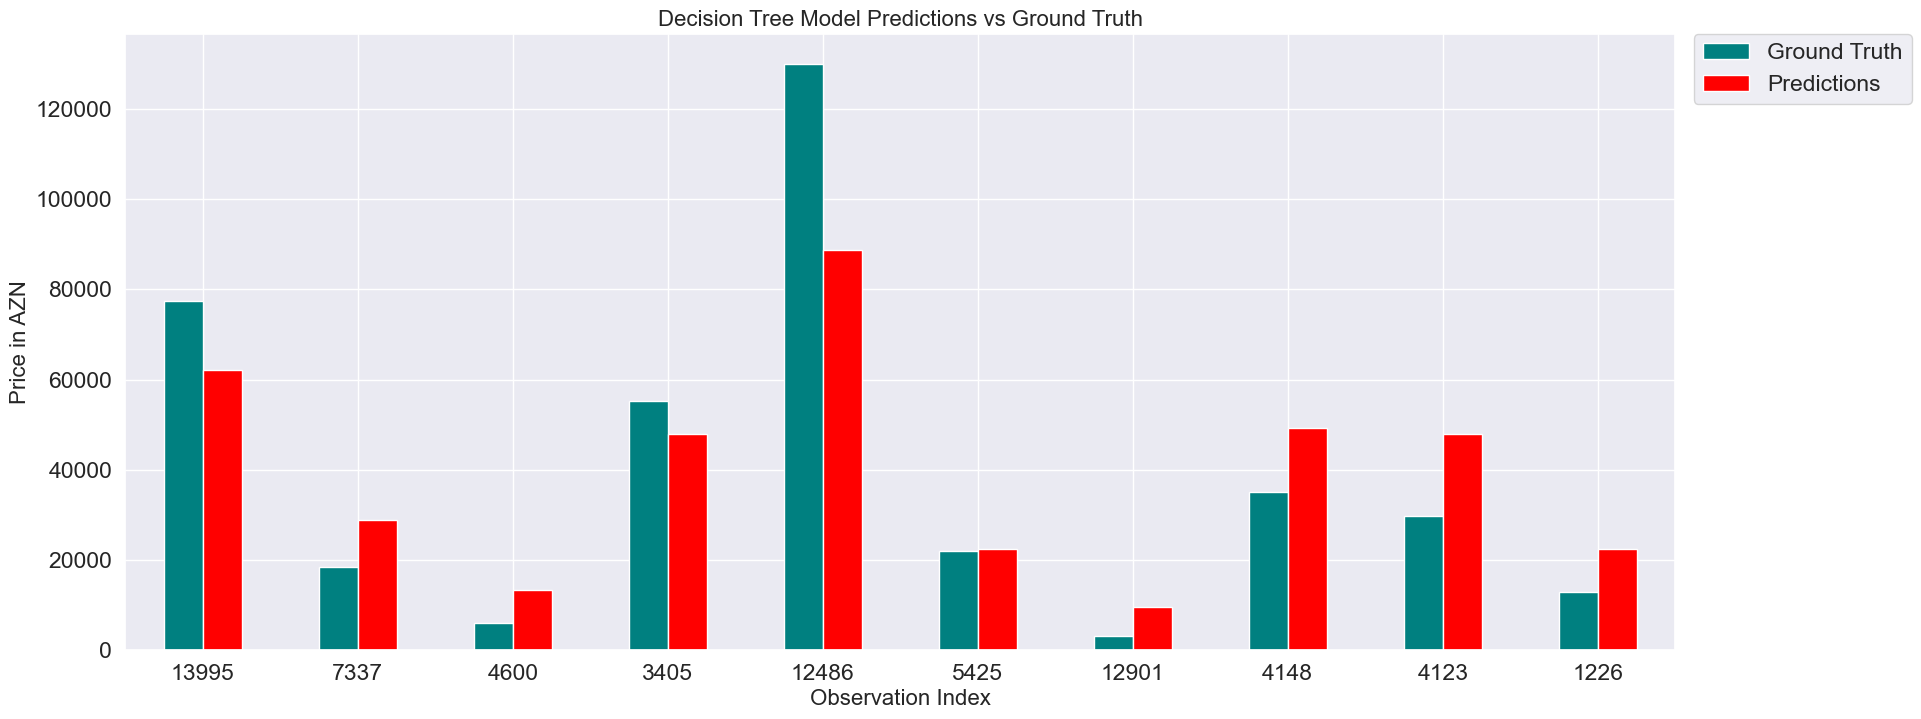

In [26]:
# Calling the function to visualize the predictions of the regressor pipeline given the test features
visualize_predictions(model = dt_model, 
                      test_features = X_test,
                      test_labels = y_test, 
                      algorithm_name = "Decision Tree")

Let's call the function to evaluate the performance of the regressor pipeline.

In [27]:
# Calling the function to evaluate the performance of the regressor pipeline
dt_model_summary_df = evaluate_performance(model = dt_model,
                                           train_features = X_train,
                                           train_labels = y_train,
                                           test_features = X_test,
                                           test_labels = y_test,
                                           algorithm_name = "Decision Tree")
# Displaying the evaluation summary
dt_model_summary_df

,Train R2,Test R2,Train Adjusted R2,Test Adjusted R2,Train MAE,Test MAE,Train MAPE,Test MAPE,Train MSE,Test MSE,Train RMSE,Test RMSE,Mean CV,Max CV,Min CV,Std CV
Decision Tree,0.89,0.8,0.89,0.8,8825.19,9597.1,0.28,0.32,2.986637e+08,5.457183e+08,17281.89,23360.61,0.84,0.86,0.8,0.02


***
## Random Forest

Let's call the function to a regressor pipeline.

In [28]:
# Creating an operating level seed
np.random.seed(seed = 42)

# Creating a dictionary of hyperparameters
search_spaces = {}
search_spaces["feature_selector__threshold"] = skopt.space.Categorical(categories = [None, "median"])
search_spaces["regressor__n_estimators"] = skopt.space.Integer(low = 100, high = 300)
search_spaces["regressor__max_depth"] = skopt.space.Integer(low = 2, high = 6)
search_spaces["regressor__min_samples_split"] = skopt.space.Integer(low = 2, high = 6)
search_spaces["regressor__min_samples_leaf"] = skopt.space.Integer(low = 1, high = 6)
search_spaces["regressor__max_features"] = skopt.space.Categorical(categories = ["auto", "sqrt", "log2"])

# Calling the function to build a regressor pipeline
rf_model = build_pipeline(regressor = RandomForestRegressor(oob_score = True, n_jobs = -1, random_state = 42),
                          train_features = X_train,
                          train_labels = y_train, 
                          apply_feature_selection = True,
                          feature_selector_type = "meta", 
                          tune_hyperparameters = True,
                          hyperparameters = search_spaces,
                          n_iterations = 100,
                          verbosity = 1)

# Logging information to the logger file
logging.info(msg = "Random Forest model has been trained")

# Displaying the architecture of the pipeline
rf_model

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

Pipeline(steps=[('initial_preprocessor', InitialPreprocessor()),
                ('feature_transformer',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('nominal_pipeline',
                                                  Pipeline(steps=[('imputer',
                                                                   CustomImputer(strategy='most_frequent')),
                                                                  ('rle',
                                                                   RareLabelEncoder(n_categories=6)),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['vehicle_type', 'brand',
                                                   'origin', 'color',
                                                   'fu...
                                                   'avg_mileage_per_year'])])),
                ('constant_feature_dropper', ConstantDropper()),
                ('dtype_converter', DataTypeConverter()),
                ('feature_selector',
                 SelectFromModel(estimator=RandomForestRegressor(n_jobs=-1,
                                                                 oob_score=True,
                                                                 random_state=42),
                                 threshold='median')),
                ('regressor',
                 RandomForestRegressor(max_depth=6, n_estimators=199, n_jobs=-1,
                                       oob_score=True, random_state=42))])

Let's call the function to visualize the predictions of the regressor pipeline given the test features.

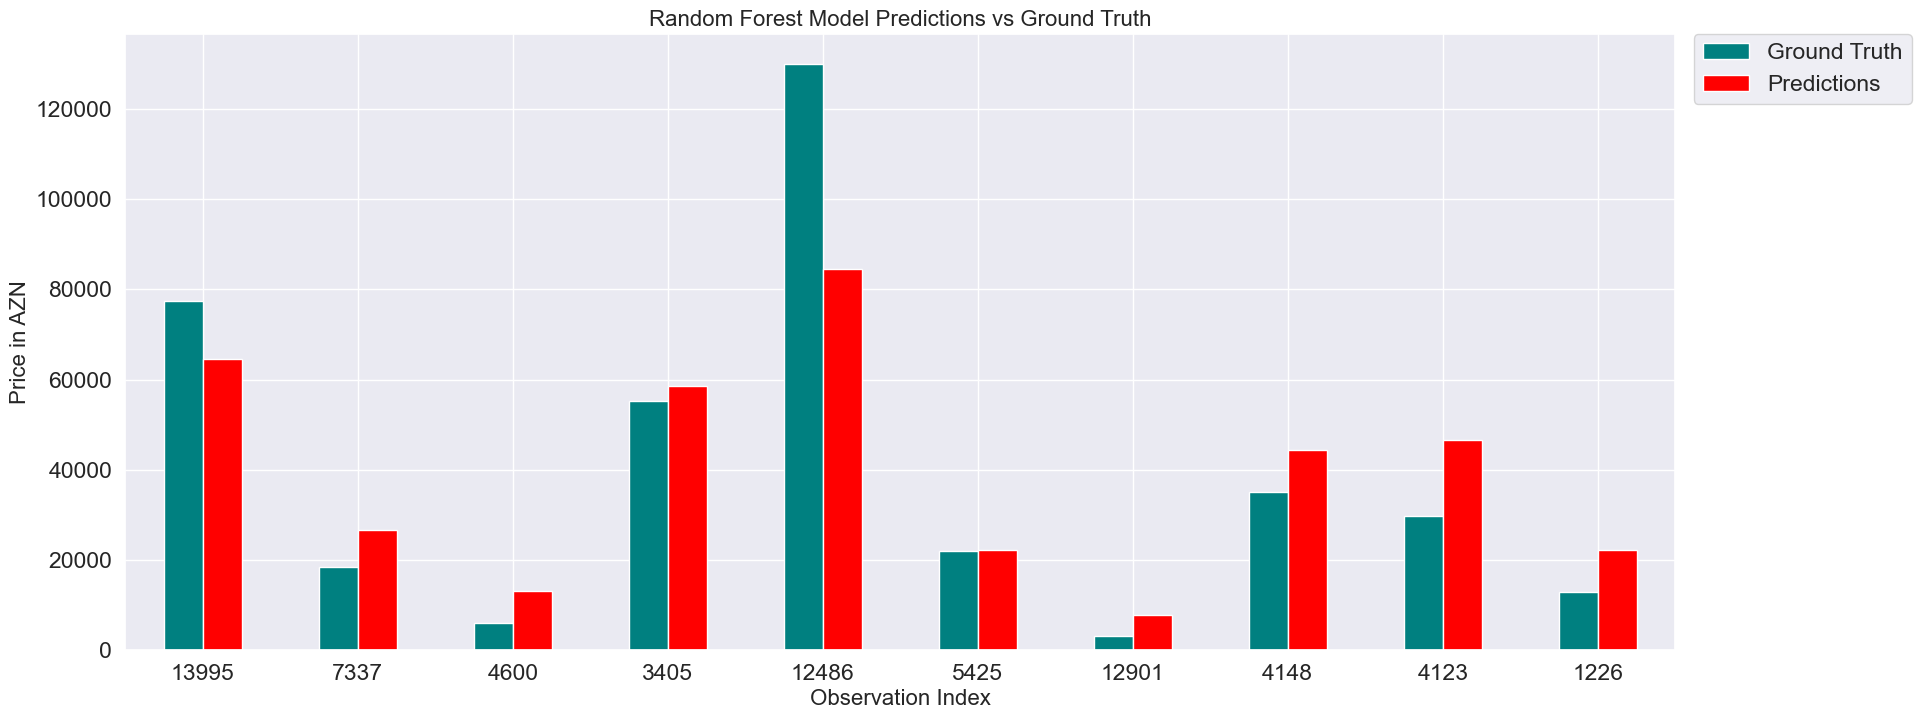

In [29]:
# Calling the function to visualize the predictions of the regressor pipeline given the test features
visualize_predictions(model = rf_model, 
                      test_features = X_test,
                      test_labels = y_test, 
                      algorithm_name = "Random Forest")

Let's call the function to evaluate the performance of the regressor pipeline.

In [30]:
# Calling the function to evaluate the performance of the regressor pipeline
rf_model_summary_df = evaluate_performance(model = rf_model,
                                           train_features = X_train,
                                           train_labels = y_train,
                                           test_features = X_test,
                                           test_labels = y_test,
                                           algorithm_name = "Random Forest")
# Displaying the evaluation summary
rf_model_summary_df

,Train R2,Test R2,Train Adjusted R2,Test Adjusted R2,Train MAE,Test MAE,Train MAPE,Test MAPE,Train MSE,Test MSE,Train RMSE,Test RMSE,Mean CV,Max CV,Min CV,Std CV
Random Forest,0.92,0.88,0.92,0.88,7785.04,8360.84,0.27,0.29,2.168566e+08,3.416006e+08,14726.05,18482.44,0.89,0.9,0.85,0.02


***
## Adaptive Boosting (ADABoost)

Let's call the function to a regressor pipeline.

In [31]:
# Creating an operating level seed
np.random.seed(seed = 42)

# Creating a dictionary of hyperparameters
search_spaces = {}
search_spaces["feature_selector__threshold"] = skopt.space.Categorical(categories = [None, "median"])
search_spaces["regressor__n_estimators"] = skopt.space.Integer(low = 100, high = 300)
search_spaces["regressor__learning_rate"] = skopt.space.Real(low = 1e-6, high = 1.0, prior = "log-uniform")
search_spaces["regressor__loss"] = skopt.space.Categorical(categories = ["linear", "square", "exponential"])

# Calling the function to build a regressor pipeline
ada_model = build_pipeline(regressor = AdaBoostRegressor(random_state = 42),
                           train_features = X_train,
                           train_labels = y_train, 
                           apply_feature_selection = True,
                           feature_selector_type = "meta", 
                           tune_hyperparameters = True,
                           hyperparameters = search_spaces,
                           n_iterations = 100,
                           verbosity = 1)

# Logging information to the logger file
logging.info(msg = "Adaptive Boosting model has been trained")

# Displaying the architecture of the pipeline
ada_model

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

Pipeline(steps=[('initial_preprocessor', InitialPreprocessor()),
                ('feature_transformer',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('nominal_pipeline',
                                                  Pipeline(steps=[('imputer',
                                                                   CustomImputer(strategy='most_frequent')),
                                                                  ('rle',
                                                                   RareLabelEncoder(n_categories=6)),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['vehicle_type', 'brand',
                                                   'origin', 'color',
                                                   'fu...
                                                  ['age', 'engine', 'mileage',
                                                   'hp',
                                                   'avg_mileage_per_year'])])),
                ('constant_feature_dropper', ConstantDropper()),
                ('dtype_converter', DataTypeConverter()),
                ('feature_selector',
                 SelectFromModel(estimator=AdaBoostRegressor(random_state=42))),
                ('regressor',
                 AdaBoostRegressor(learning_rate=0.012144268370314975,
                                   loss='exponential', n_estimators=300,
                                   random_state=42))])

Let's call the function to visualize the predictions of the regressor pipeline given the test features.

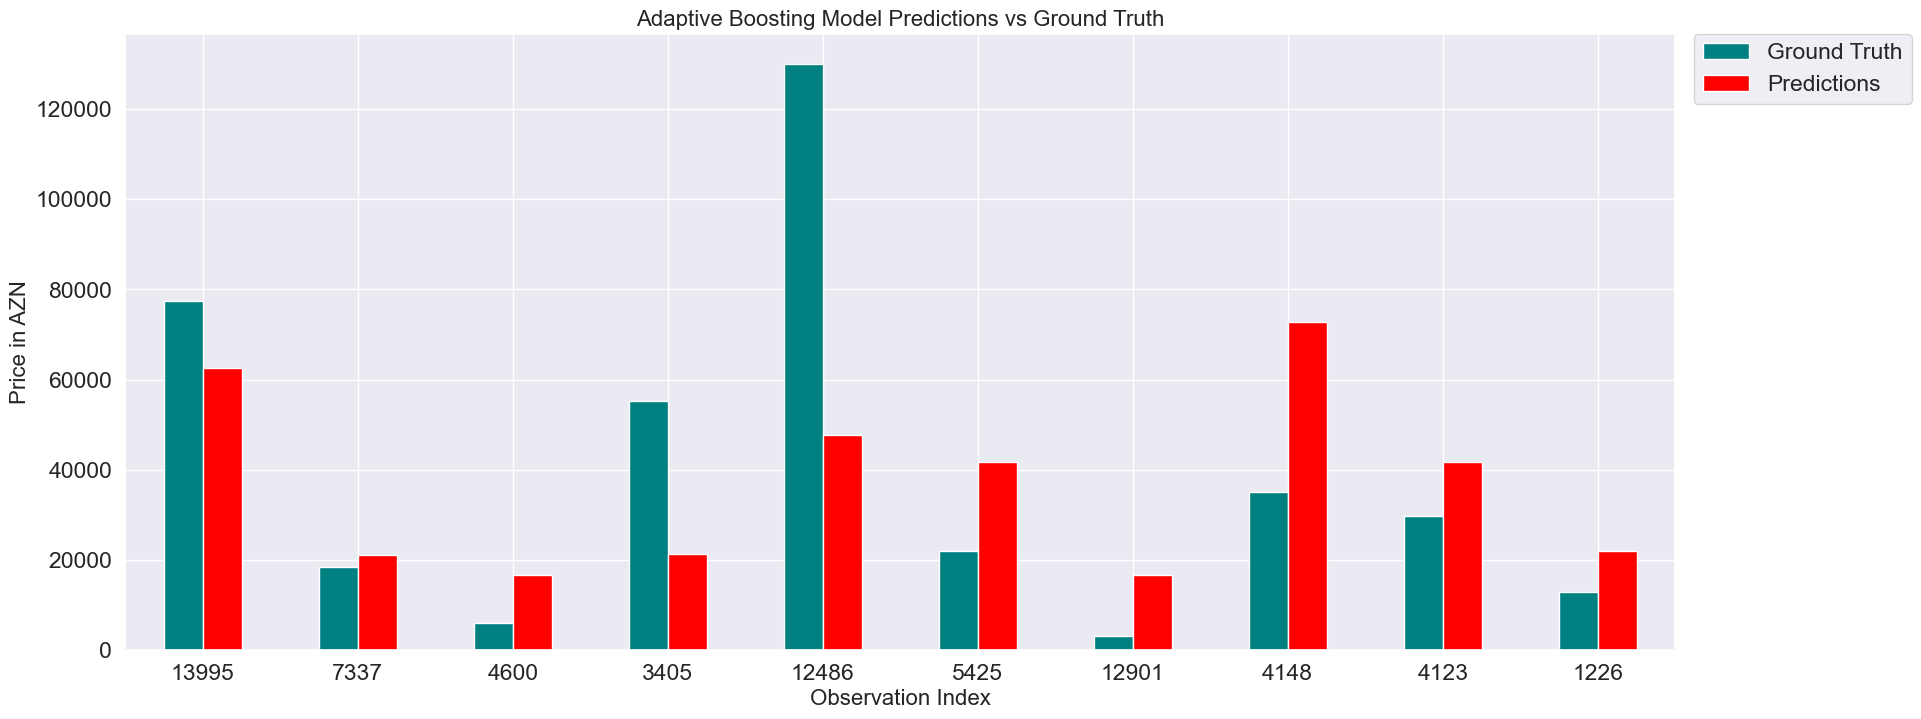

In [32]:
# Calling the function to visualize the predictions of the regressor pipeline given the test features
visualize_predictions(model = ada_model, 
                      test_features = X_test,
                      test_labels = y_test, 
                      algorithm_name = "Adaptive Boosting")

Let's call the function to evaluate the performance of the regressor pipeline.

In [33]:
# Calling the function to evaluate the performance of the regressor pipeline
ada_model_summary_df = evaluate_performance(model = ada_model,
                                            train_features = X_train,
                                            train_labels = y_train,
                                            test_features = X_test,
                                            test_labels = y_test,
                                            algorithm_name = "Adaptive Boosting")
# Displaying the evaluation summary
ada_model_summary_df

,Train R2,Test R2,Train Adjusted R2,Test Adjusted R2,Train MAE,Test MAE,Train MAPE,Test MAPE,Train MSE,Test MSE,Train RMSE,Test RMSE,Mean CV,Max CV,Min CV,Std CV
Adaptive Boosting,0.82,0.78,0.82,0.78,13651.72,13689.13,0.65,0.68,5.045309e+08,6.043126e+08,22461.77,24582.77,0.8,0.82,0.77,0.02


***
## Light Gradient Boosting (LightGBM)

Let's call the function to a regressor pipeline.

In [34]:
# Creating an operating level seed
np.random.seed(seed = 42)

# Creating a dictionary of hyperparameters
search_spaces = {}
search_spaces["feature_selector__threshold"] = skopt.space.Categorical(categories = [None, "median"])
search_spaces["regressor__max_depth"] = skopt.space.Integer(low = 2, high = 6)
search_spaces["regressor__learning_rate"] = skopt.space.Real(low = 1e-6, high = 0.1, prior = "log-uniform")
search_spaces["regressor__n_estimators"] = skopt.space.Integer(low = 100, high = 300)
search_spaces["regressor__min_child_weight"] = skopt.space.Real(low = 1e-6, high = 0.1, prior = "log-uniform")
search_spaces["regressor__reg_alpha"] = skopt.space.Real(low = 1e-6, high = 0.1, prior = "log-uniform")
search_spaces["regressor__reg_lambda"] = skopt.space.Real(low = 1e-6, high = 0.1, prior = "log-uniform")

# Calling the function to build a regressor pipeline
lgbm_model = build_pipeline(regressor = LGBMRegressor(random_state = 42, objective = eval_metric, n_jobs = -1),
                            train_features = X_train,
                            train_labels = y_train, 
                            apply_feature_selection = True,
                            feature_selector_type = "meta", 
                            tune_hyperparameters = True,
                            hyperparameters = search_spaces,
                            n_iterations = 100,
                            verbosity = 1)

# Logging information to the logger file
logging.info(msg = "Light Gradient Boosting model has been trained")

# Displaying the architecture of the pipeline
lgbm_model

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

Pipeline(steps=[('initial_preprocessor', InitialPreprocessor()),
                ('feature_transformer',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('nominal_pipeline',
                                                  Pipeline(steps=[('imputer',
                                                                   CustomImputer(strategy='most_frequent')),
                                                                  ('rle',
                                                                   RareLabelEncoder(n_categories=6)),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['vehicle_type', 'brand',
                                                   'origin', 'color',
                                                   'fu...
                                                   'avg_mileage_per_year'])])),
                ('constant_feature_dropper', ConstantDropper()),
                ('dtype_converter', DataTypeConverter()),
                ('feature_selector',
                 SelectFromModel(estimator=LGBMRegressor(objective='mse',
                                                         random_state=42),
                                 threshold='median')),
                ('regressor',
                 LGBMRegressor(max_depth=6, min_child_weight=1e-06,
                               n_estimators=300, objective='mse',
                               random_state=42, reg_alpha=0.1,
                               reg_lambda=1e-06))])

Let's call the function to visualize the predictions of the regressor pipeline given the test features.

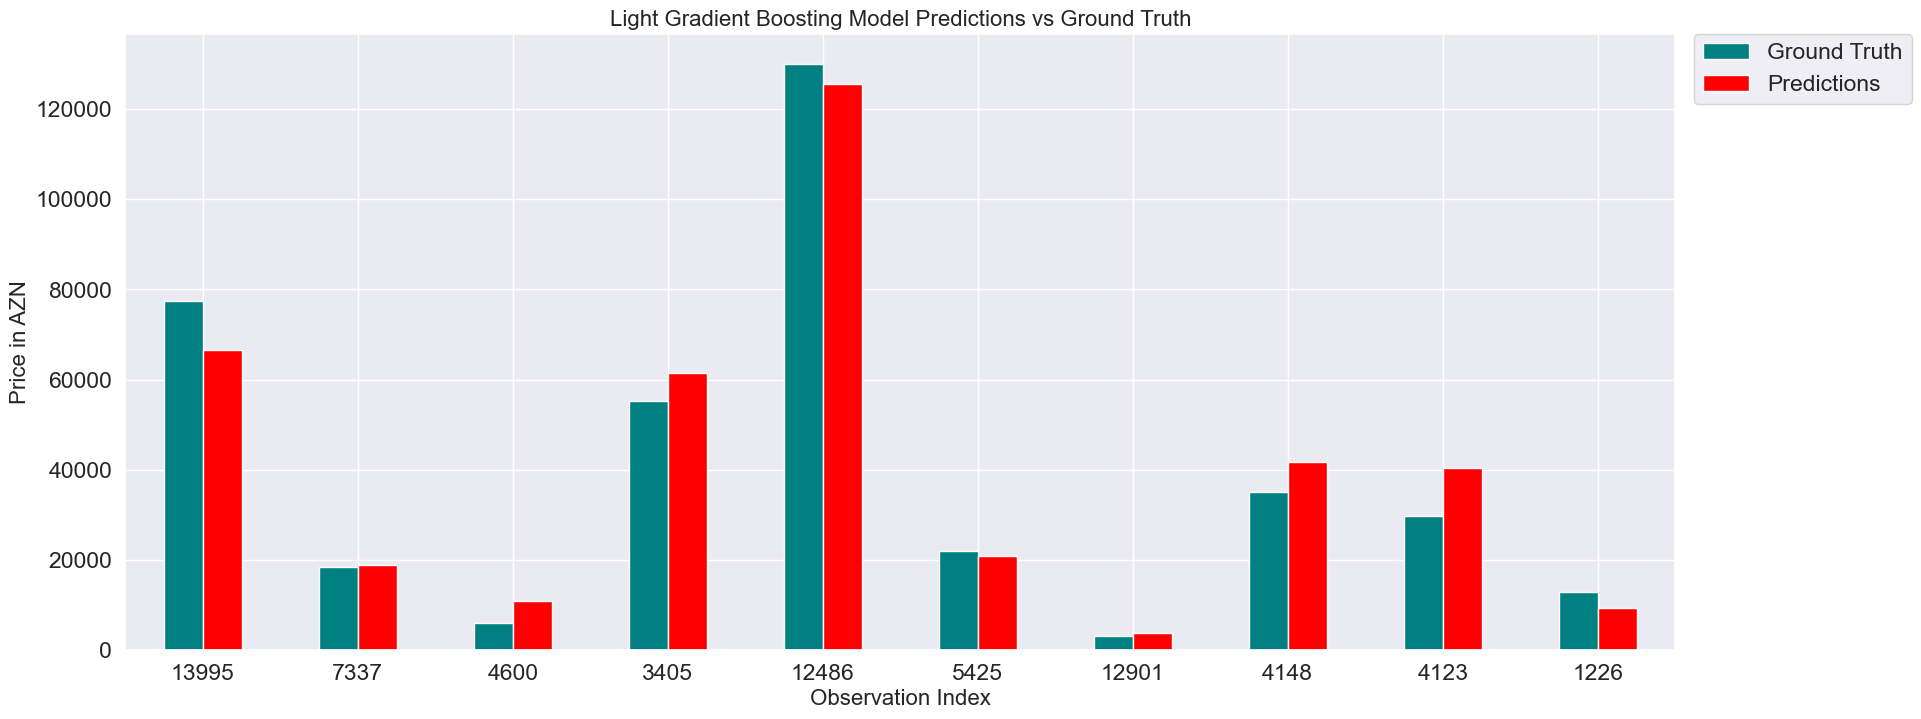

In [35]:
# Calling the function to visualize the predictions of the regressor pipeline given the test features
visualize_predictions(model = lgbm_model, 
                      test_features = X_test,
                      test_labels = y_test, 
                      algorithm_name = "Light Gradient Boosting")

Let's call the function to evaluate the performance of the regressor pipeline.

In [36]:
# Calling the function to evaluate the performance of the regressor pipeline
lgbm_model_summary_df = evaluate_performance(model = lgbm_model,
                                             train_features = X_train,
                                             train_labels = y_train,
                                             test_features = X_test,
                                             test_labels = y_test,
                                             algorithm_name = "Light Gradient Boosting")
# Displaying the evaluation summary
lgbm_model_summary_df

,Train R2,Test R2,Train Adjusted R2,Test Adjusted R2,Train MAE,Test MAE,Train MAPE,Test MAPE,Train MSE,Test MSE,Train RMSE,Test RMSE,Mean CV,Max CV,Min CV,Std CV
Light Gradient Boosting,0.98,0.94,0.98,0.94,3991.64,5079.78,0.14,0.17,58278601.6,1.610828e+08,7634.04,12691.84,0.93,0.95,0.92,0.01


***
## Gradient Boosting

Let's call the function to a regressor pipeline.

In [37]:
# Creating an operating level seed
np.random.seed(seed = 42)

# Creating a dictionary of hyperparameters
search_spaces = {}
search_spaces["feature_selector__threshold"] = skopt.space.Categorical(categories = [None, "median"])
search_spaces["regressor__learning_rate"] = skopt.space.Real(low = 1e-6, high = 0.1, prior = "log-uniform")
search_spaces["regressor__n_estimators"] = skopt.space.Integer(low = 100, high = 300)
search_spaces["regressor__min_samples_split"] = skopt.space.Integer(low = 2, high = 6)
search_spaces["regressor__min_samples_leaf"] = skopt.space.Integer(low = 1, high = 6)
search_spaces["regressor__max_features"] = skopt.space.Categorical(categories = ["auto", "sqrt", "log2"])
search_spaces["regressor__n_iter_no_change"] = skopt.space.Categorical(categories = [3, 5, 7])

# Calling the function to build a regressor pipeline
gbm_model = build_pipeline(regressor = GradientBoostingRegressor(random_state = 42),
                           train_features = X_train,
                           train_labels = y_train, 
                           apply_feature_selection = True,
                           feature_selector_type = "meta", 
                           tune_hyperparameters = True,
                           hyperparameters = search_spaces,
                           n_iterations = 100,
                           verbosity = 1)

# Logging information to the logger file
logging.info(msg = "Gradient Boosting model has been trained")

# Displaying the architecture of the pipeline
gbm_model

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

Pipeline(steps=[('initial_preprocessor', InitialPreprocessor()),
                ('feature_transformer',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('nominal_pipeline',
                                                  Pipeline(steps=[('imputer',
                                                                   CustomImputer(strategy='most_frequent')),
                                                                  ('rle',
                                                                   RareLabelEncoder(n_categories=6)),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['vehicle_type', 'brand',
                                                   'origin', 'color',
                                                   'fu...
                                                   'avg_mileage_per_year'])])),
                ('constant_feature_dropper', ConstantDropper()),
                ('dtype_converter', DataTypeConverter()),
                ('feature_selector',
                 SelectFromModel(estimator=GradientBoostingRegressor(random_state=42),
                                 threshold='median')),
                ('regressor',
                 GradientBoostingRegressor(max_features='auto',
                                           min_samples_leaf=6, n_estimators=299,
                                           n_iter_no_change=7,
                                           random_state=42))])

Let's call the function to visualize the predictions of the regressor pipeline given the test features.

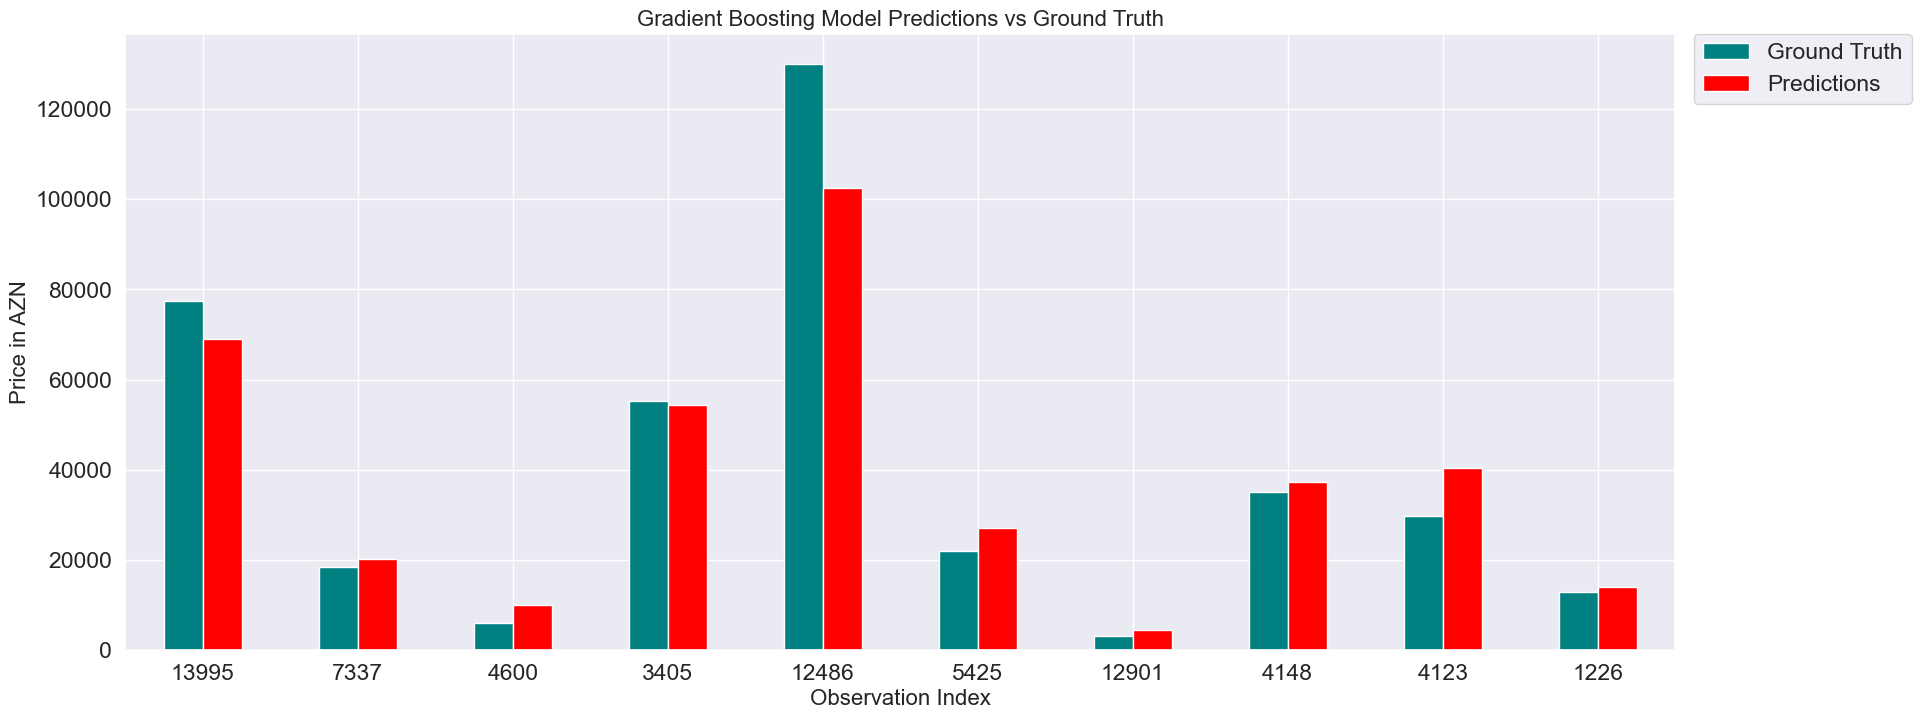

In [38]:
# Calling the function to visualize the predictions of the regressor pipeline given the test features
visualize_predictions(model = gbm_model, 
                      test_features = X_test,
                      test_labels = y_test, 
                      algorithm_name = "Gradient Boosting")

Let's call the function to evaluate the performance of the regressor pipeline.

In [39]:
# Calling the function to evaluate the performance of the regressor pipeline
gbm_model_summary_df = evaluate_performance(model = gbm_model,
                                            train_features = X_train,
                                            train_labels = y_train,
                                            test_features = X_test,
                                            test_labels = y_test,
                                            algorithm_name = "Gradient Boosting")
# Displaying the evaluation summary
gbm_model_summary_df

,Train R2,Test R2,Train Adjusted R2,Test Adjusted R2,Train MAE,Test MAE,Train MAPE,Test MAPE,Train MSE,Test MSE,Train RMSE,Test RMSE,Mean CV,Max CV,Min CV,Std CV
Gradient Boosting,0.94,0.91,0.94,0.91,6415.38,6713.74,0.21,0.22,1.654673e+08,2.549824e+08,12863.41,15968.17,0.92,0.93,0.9,0.01


***
## Extreme Gradient Boosting (XGBoost)

Let's call the function to a regressor pipeline.

In [40]:
# Creating an operating level seed
np.random.seed(seed = 42)

# Creating a dictionary of hyperparameters
search_spaces = {}
search_spaces["feature_selector__threshold"] = skopt.space.Categorical(categories = [None, "median"])
search_spaces["regressor__n_estimators"] = skopt.space.Integer(low = 100, high = 300)
search_spaces["regressor__max_depth"] = skopt.space.Integer(low = 2, high = 6)
search_spaces["regressor__learning_rate"] = skopt.space.Real(low = 1e-6, high = 0.1, prior = "log-uniform")

# Calling the function to build a regressor pipeline
xgbm_model = build_pipeline(regressor = XGBRegressor(n_jobs = -1, random_state = 42),
                            train_features = X_train,
                            train_labels = y_train, 
                            apply_feature_selection = True,
                            feature_selector_type = "meta", 
                            tune_hyperparameters = True,
                            hyperparameters = search_spaces,
                            n_iterations = 100,
                            verbosity = 1)

# Logging information to the logger file
logging.info(msg = "Extreme Gradient Boosting model has been trained")

# Displaying the architecture of the pipeline
xgbm_model

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

Pipeline(steps=[('initial_preprocessor', InitialPreprocessor()),
                ('feature_transformer',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('nominal_pipeline',
                                                  Pipeline(steps=[('imputer',
                                                                   CustomImputer(strategy='most_frequent')),
                                                                  ('rle',
                                                                   RareLabelEncoder(n_categories=6)),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['vehicle_type', 'brand',
                                                   'origin', 'color',
                                                   'fu...
                              gamma=0, gpu_id=-1, importance_type=None,
                              interaction_constraints='',
                              learning_rate=0.08423265773806858,
                              max_delta_step=0, max_depth=6, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=300, n_jobs=-1, num_parallel_tree=1,
                              predictor='auto', random_state=42, reg_alpha=0,
                              reg_lambda=1, scale_pos_weight=1, subsample=1,
                              tree_method='exact', validate_parameters=1,
                              verbosity=None))])

Let's call the function to visualize the predictions of the regressor pipeline given the test features.

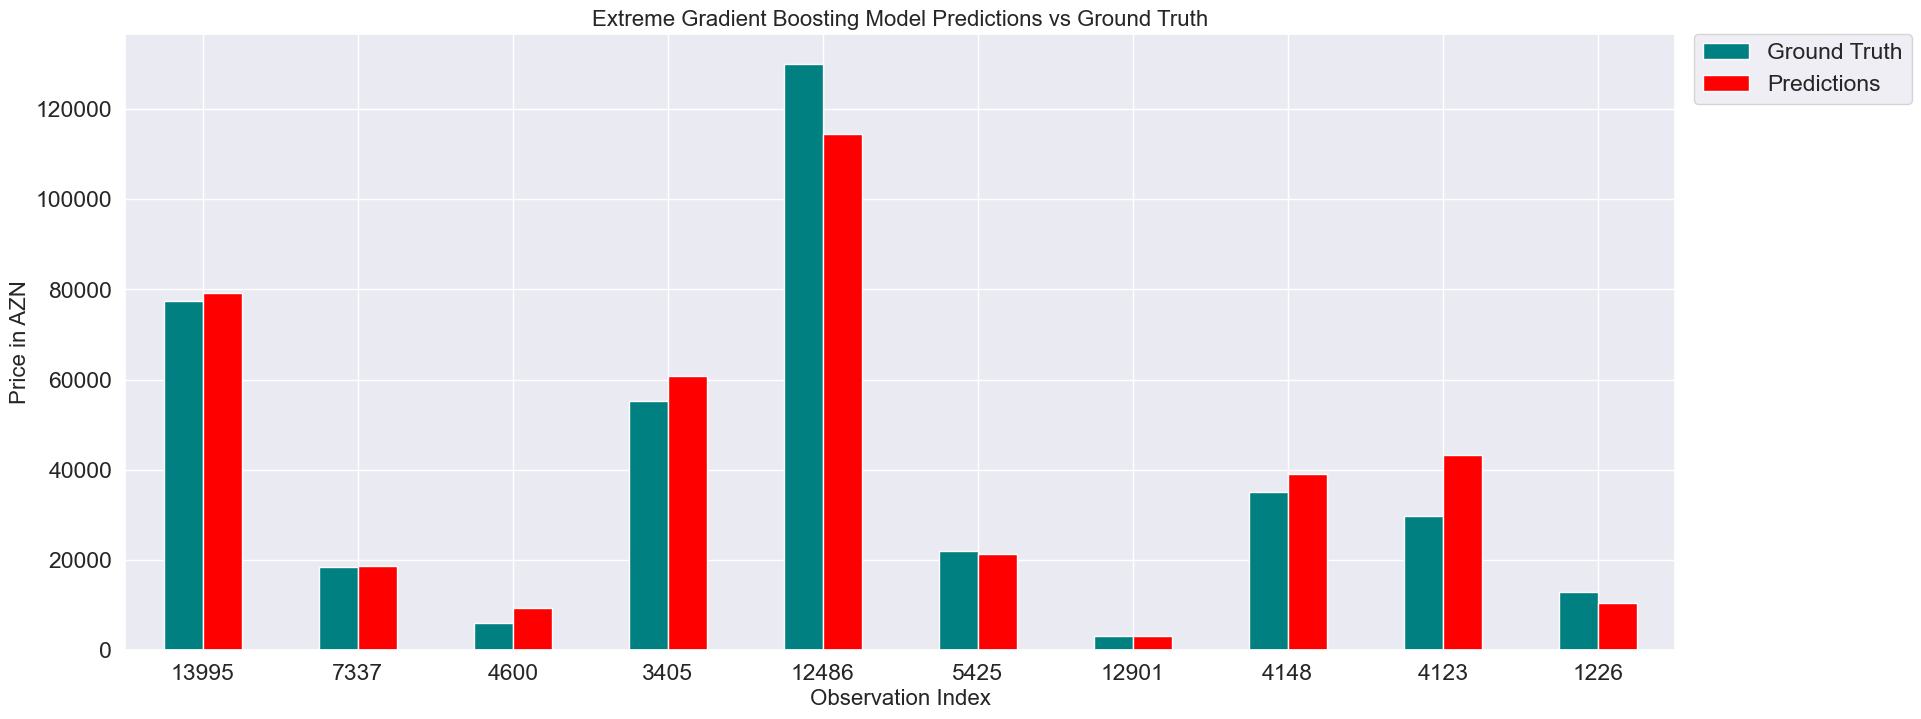

In [41]:
# Calling the function to visualize the predictions of the regressor pipeline given the test features
visualize_predictions(model = xgbm_model, 
                      test_features = X_test,
                      test_labels = y_test, 
                      algorithm_name = "Extreme Gradient Boosting")

Let's call the function to evaluate the performance of the regressor pipeline.

In [42]:
# Calling the function to evaluate the performance of the regressor pipeline
xgbm_model_summary_df = evaluate_performance(model = xgbm_model,
                                             train_features = X_train,
                                             train_labels = y_train,
                                             test_features = X_test,
                                             test_labels = y_test,
                                             algorithm_name = "Extreme Gradient Boosting")
# Displaying the evaluation summary
xgbm_model_summary_df

,Train R2,Test R2,Train Adjusted R2,Test Adjusted R2,Train MAE,Test MAE,Train MAPE,Test MAPE,Train MSE,Test MSE,Train RMSE,Test RMSE,Mean CV,Max CV,Min CV,Std CV
Extreme Gradient Boosting,0.99,0.93,0.99,0.93,2771.06,4624.82,0.11,0.15,22163818.55,1.880002e+08,4707.85,13711.32,0.94,0.95,0.93,0.01


***
## Category Boosting (CatBoost)

Let's call the function to a regressor pipeline.

In [43]:
# Calling the function to build a regressor pipeline
cb_model = build_pipeline(regressor = CatBoostRegressor(verbose = 0, random_state = 42),
                          train_features = X_train,
                          train_labels = y_train, 
                          apply_feature_selection = True,
                          feature_selector_type = "meta")

# Logging information to the logger file
logging.info(msg = "Category Boosting model has been trained")

# Displaying the architecture of the pipeline
cb_model

Pipeline(steps=[('initial_preprocessor', InitialPreprocessor()),
                ('feature_transformer',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('nominal_pipeline',
                                                  Pipeline(steps=[('imputer',
                                                                   CustomImputer(strategy='most_frequent')),
                                                                  ('rle',
                                                                   RareLabelEncoder(n_categories=6)),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['vehicle_type', 'brand',
                                                   'origin', 'color',
                                                   'fu...
                                                                   CustomImputer(strategy='median'))]),
                                                  ['age', 'engine', 'mileage',
                                                   'hp',
                                                   'avg_mileage_per_year'])])),
                ('constant_feature_dropper', ConstantDropper()),
                ('dtype_converter', DataTypeConverter()),
                ('feature_selector',
                 SelectFromModel(estimator=<catboost.core.CatBoostRegressor object at 0x7fdc29c2dee0>)),
                ('regressor',
                 <catboost.core.CatBoostRegressor object at 0x7fdc29c2dee0>)])

Let's call the function to visualize the predictions of the regressor pipeline given the test features.

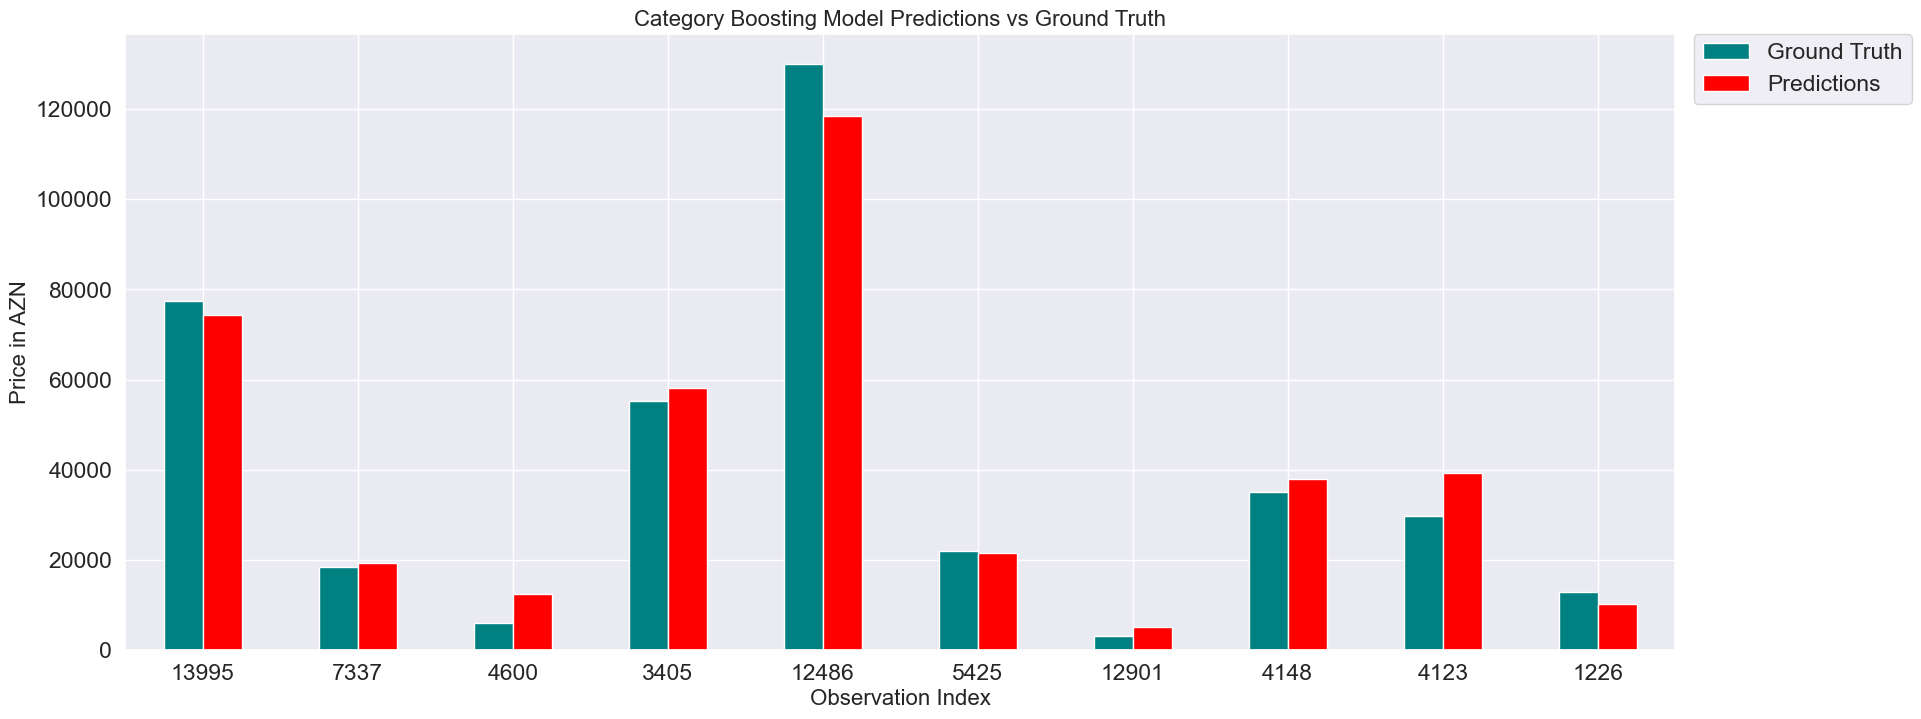

In [44]:
# Calling the function to visualize the predictions of the regressor pipeline given the test features
visualize_predictions(model = cb_model, 
                      test_features = X_test,
                      test_labels = y_test, 
                      algorithm_name = "Category Boosting")

Let's call the function to evaluate the performance of the regressor pipeline.

In [45]:
# Calling the function to evaluate the performance of the regressor pipeline
cb_model_summary_df = evaluate_performance(model = cb_model,
                                           train_features = X_train,
                                           train_labels = y_train,
                                           test_features = X_test,
                                           test_labels = y_test,
                                           algorithm_name = "Category Boosting")
# Displaying the evaluation summary
cb_model_summary_df

,Train R2,Test R2,Train Adjusted R2,Test Adjusted R2,Train MAE,Test MAE,Train MAPE,Test MAPE,Train MSE,Test MSE,Train RMSE,Test RMSE,Mean CV,Max CV,Min CV,Std CV
Category Boosting,0.98,0.94,0.98,0.94,4276.42,5172.31,0.15,0.18,63866568.91,1.786054e+08,7991.66,13364.33,0.94,0.95,0.92,0.01


***
## Stacked (LightGBM + XGBoost + CatBoost)

Let's create a list of regressor pipelines and build a **stacked** model.

In [46]:
# Creating a list of regressor pipelines
regressors = [("lgbm_model", lgbm_model), ("xgbm_model", xgbm_model), ("cb_model", cb_model)]

# Creating an instance of stacked regressor pipeline
stacked_model = StackingRegressor(estimators = regressors)

# Logging information to the logger file
logging.info(msg = "Stacked model has been trained")

# Fitting train features and labels
stacked_model.fit(X = X_train, y = y_train)

StackingRegressor(estimators=[('lgbm_model',
                               Pipeline(steps=[('initial_preprocessor',
                                                InitialPreprocessor()),
                                               ('feature_transformer',
                                                ColumnTransformer(n_jobs=-1,
                                                                  transformers=[('nominal_pipeline',
                                                                                 Pipeline(steps=[('imputer',
                                                                                                  CustomImputer(strategy='most_frequent')),
                                                                                                 ('rle',
                                                                                                  RareLabelEncoder(n_categories=6)),
                                                                                                 ('ohe',
                                                                                                  OneHotEncoder(handle_unknown='ignore'))]),...
                                                                                                  CustomImputer(strategy='median'))]),
                                                                                 ['age',
                                                                                  'engine',
                                                                                  'mileage',
                                                                                  'hp',
                                                                                  'avg_mileage_per_year'])])),
                                               ('constant_feature_dropper',
                                                ConstantDropper()),
                                               ('dtype_converter',
                                                DataTypeConverter()),
                                               ('feature_selector',
                                                SelectFromModel(estimator=<catboost.core.CatBoostRegressor object at 0x7fdc29c2dee0>)),
                                               ('regressor',
                                                <catboost.core.CatBoostRegressor object at 0x7fdc29c2dee0>)]))])

Let's call the function to visualize the predictions of the regressor pipeline given the test features.

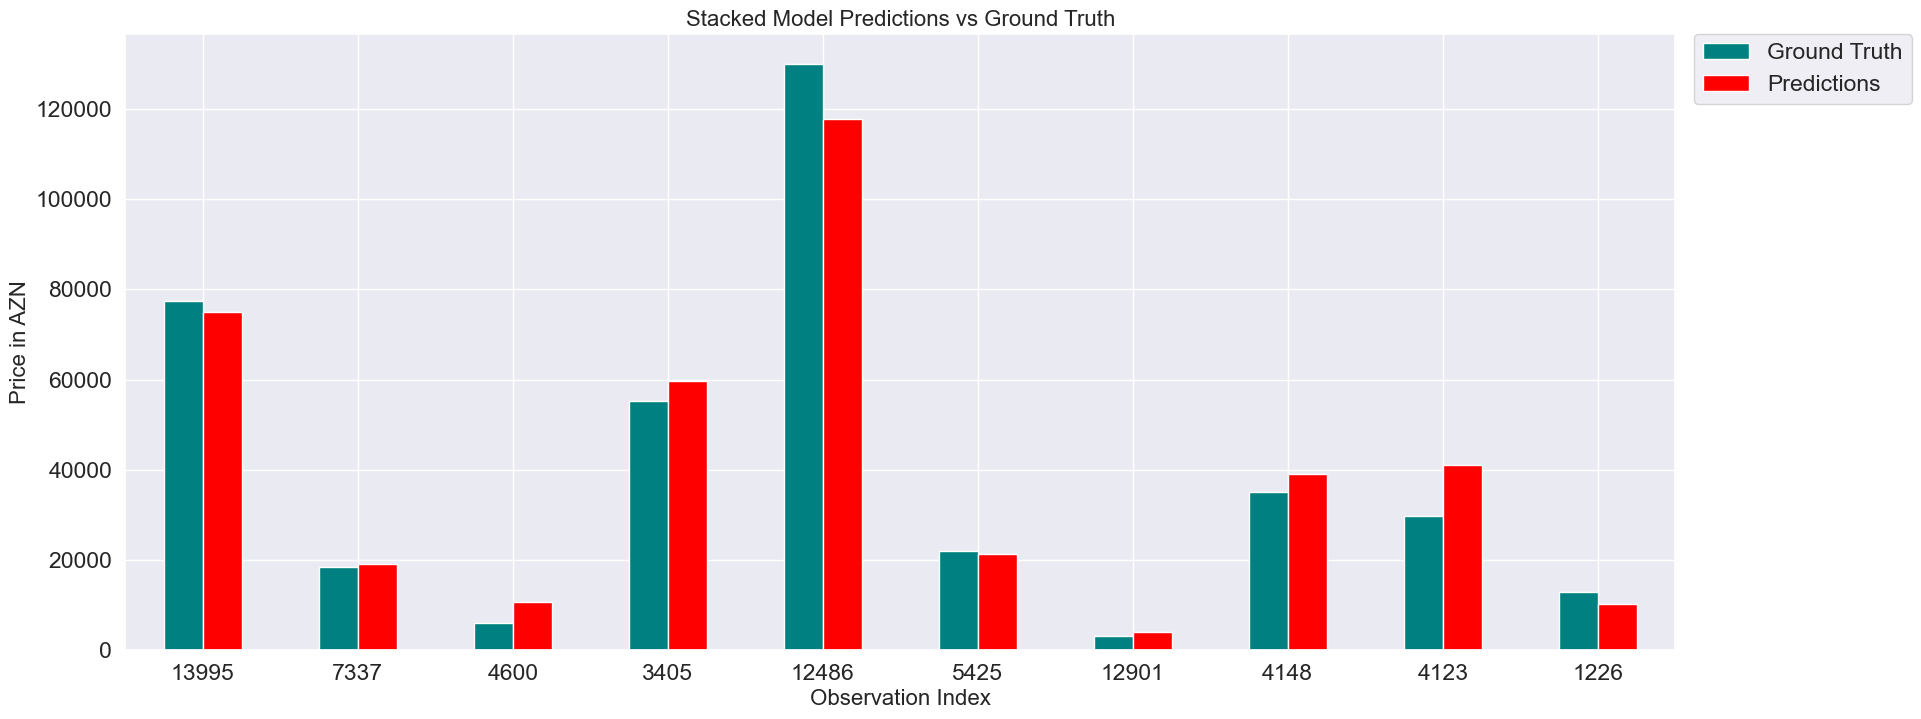

In [47]:
# Calling the function to visualize the predictions of the regressor pipeline given the test features
visualize_predictions(model = stacked_model, 
                      test_features = X_test,
                      test_labels = y_test, 
                      algorithm_name = "Stacked")

Let's call the function to evaluate the performance of the regressor pipeline.

In [48]:
# Calling the function to evaluate the performance of the regressor pipeline
stacked_model_summary_df = evaluate_performance(model = stacked_model,
                                                train_features = X_train,
                                                train_labels = y_train,
                                                test_features = X_test,
                                                test_labels = y_test,
                                                algorithm_name = "Stacked")
# Displaying the evaluation summary
stacked_model_summary_df

,Train R2,Test R2,Train Adjusted R2,Test Adjusted R2,Train MAE,Test MAE,Train MAPE,Test MAPE,Train MSE,Test MSE,Train RMSE,Test RMSE,Mean CV,Max CV,Min CV,Std CV
Stacked,0.99,0.94,0.99,0.94,3338.38,4622.12,0.12,0.15,35977460.31,1.645372e+08,5998.12,12827.2,0.94,0.95,0.93,0.01


***
## Voting (LightGBM + XGBoost + CatBoost)

Let's build a **voting** model.

In [49]:
# Creating an instance of voting regressor pipeline
voting_model = VotingRegressor(estimators = regressors)

# Logging information to the logger file
logging.info(msg = "Voting model has been trained")

# Fitting train features and labels
voting_model.fit(X = X_train, y = y_train)

VotingRegressor(estimators=[('lgbm_model',
                             Pipeline(steps=[('initial_preprocessor',
                                              InitialPreprocessor()),
                                             ('feature_transformer',
                                              ColumnTransformer(n_jobs=-1,
                                                                transformers=[('nominal_pipeline',
                                                                               Pipeline(steps=[('imputer',
                                                                                                CustomImputer(strategy='most_frequent')),
                                                                                               ('rle',
                                                                                                RareLabelEncoder(n_categories=6)),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               ['...
                                                                                                CustomImputer(strategy='median'))]),
                                                                               ['age',
                                                                                'engine',
                                                                                'mileage',
                                                                                'hp',
                                                                                'avg_mileage_per_year'])])),
                                             ('constant_feature_dropper',
                                              ConstantDropper()),
                                             ('dtype_converter',
                                              DataTypeConverter()),
                                             ('feature_selector',
                                              SelectFromModel(estimator=<catboost.core.CatBoostRegressor object at 0x7fdc29c2dee0>)),
                                             ('regressor',
                                              <catboost.core.CatBoostRegressor object at 0x7fdc29c2dee0>)]))])

Let's call the function to visualize the predictions of the regressor pipeline given the test features.

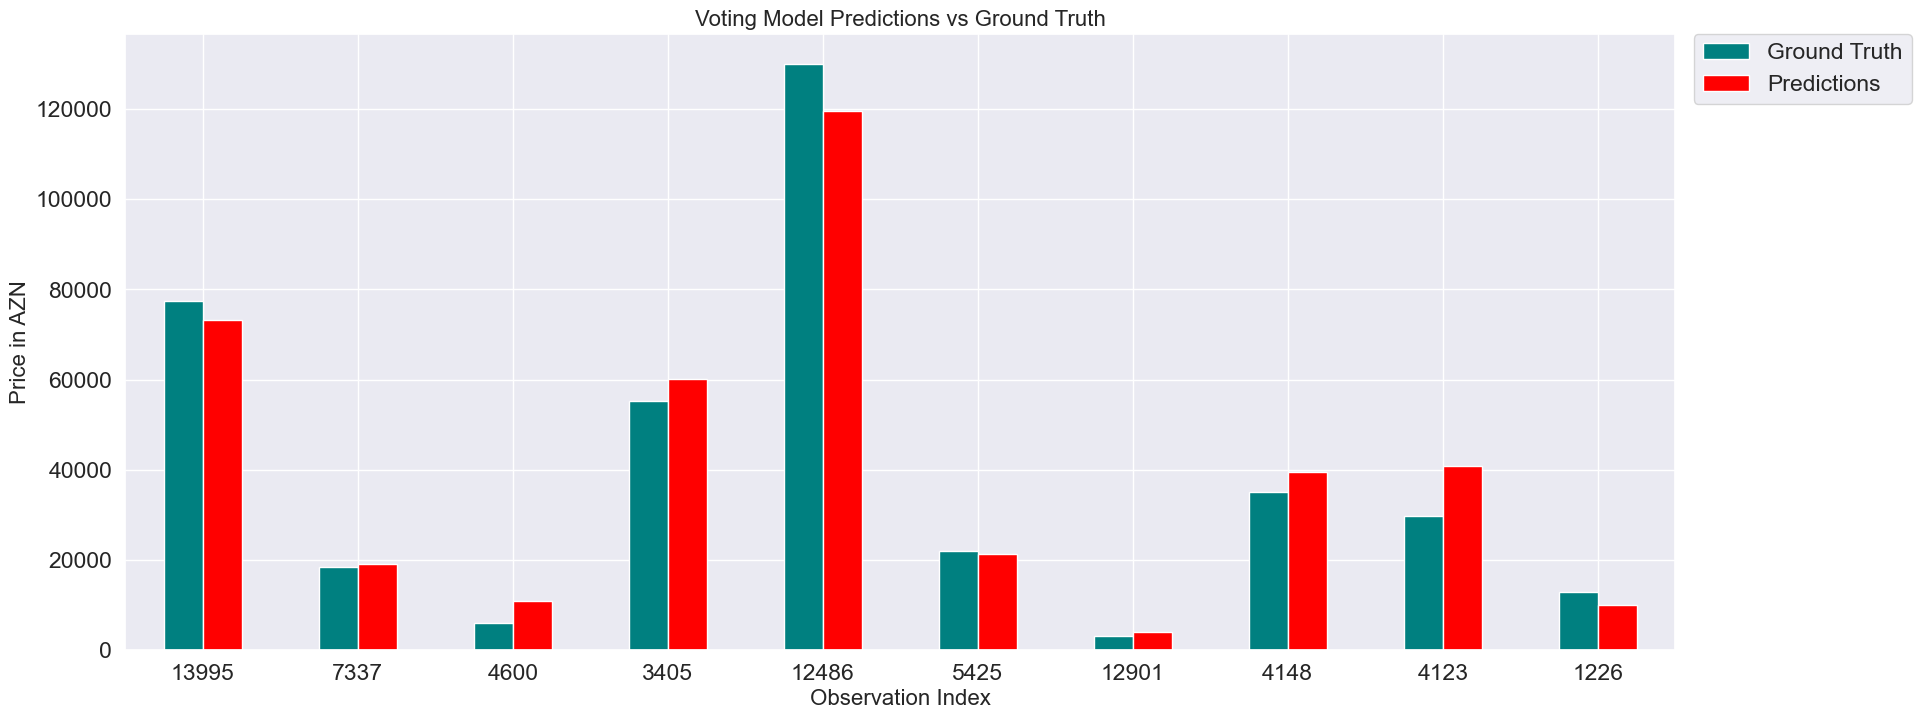

In [50]:
# Calling the function to visualize the predictions of the regressor pipeline given the test features
visualize_predictions(model = voting_model, 
                      test_features = X_test,
                      test_labels = y_test, 
                      algorithm_name = "Voting")

Let's call the function to evaluate the performance of the regressor pipeline.

In [51]:
# Calling the function to evaluate the performance of the regressor pipeline
voting_model_summary_df = evaluate_performance(model = voting_model,
                                               train_features = X_train,
                                               train_labels = y_train,
                                               test_features = X_test,
                                               test_labels = y_test,
                                               algorithm_name = "Voting")
# Displaying the evaluation summary
voting_model_summary_df

,Train R2,Test R2,Train Adjusted R2,Test Adjusted R2,Train MAE,Test MAE,Train MAPE,Test MAPE,Train MSE,Test MSE,Train RMSE,Test RMSE,Mean CV,Max CV,Min CV,Std CV
Voting,0.99,0.94,0.99,0.94,3444.92,4661.81,0.13,0.16,39179936.05,1.601509e+08,6259.39,12655.07,0.94,0.95,0.93,0.01


***
## Model Selection

Let's create a list of regressor pipeline instances, concatenate them and sort each model based on the evaluation metric.

In [52]:
# Creating a list of regressor pipeline instances
evaluation_summaries = [baseline_model_summary_df, lr_model_summary_df, br_model_summary_df, 
                        svm_model_summary_df, knn_model_summary_df, mlp_model_summary_df,
                        dt_model_summary_df, rf_model_summary_df, ada_model_summary_df,
                        lgbm_model_summary_df, gbm_model_summary_df, xgbm_model_summary_df,
                        cb_model_summary_df, stacked_model_summary_df, voting_model_summary_df]

# Concatenating the evaluation summaries and sorting based on evaluation metric
summary_df = pd.concat(objs = evaluation_summaries).sort_values(by = f"Test {eval_metric.upper()}")

# Displaying the summary
summary_df

,Train R2,Test R2,Train Adjusted R2,Test Adjusted R2,Train MAE,Test MAE,Train MAPE,Test MAPE,Train MSE,Test MSE,Train RMSE,Test RMSE,Mean CV,Max CV,Min CV,Std CV
Voting,0.99,0.94,0.99,0.94,3444.92,4661.81,0.13,0.16,3.917994e+07,1.601509e+08,6259.39,12655.07,0.94,0.95,0.93,0.01
Light Gradient Boosting,0.98,0.94,0.98,0.94,3991.64,5079.78,0.14,0.17,5.827860e+07,1.610828e+08,7634.04,12691.84,0.93,0.95,0.92,0.01
Stacked,0.99,0.94,0.99,0.94,3338.38,4622.12,0.12,0.15,3.597746e+07,1.645372e+08,5998.12,12827.20,0.94,0.95,0.93,0.01
Category Boosting,0.98,0.94,0.98,0.94,4276.42,5172.31,0.15,0.18,6.386657e+07,1.786054e+08,7991.66,13364.33,0.94,0.95,0.92,0.01
Extreme Gradient Boosting,0.99,0.93,0.99,0.93,2771.06,4624.82,0.11,0.15,2.216382e+07,1.880002e+08,4707.85,13711.32,0.94,0.95,0.93,0.01
Gradient Boosting,0.94,0.91,0.94,0.91,6415.38,6713.74,0.21,0.22,1.654673e+08,2.549824e+08,12863.41,15968.17,0.92,0.93,0.90,0.01
Support Vector Machine,0.94,0.89,0.94,0.89,4899.62,5653.77,0.12,0.15,1.602209e+08,3.054998e+08,12657.84,17478.55,0.91,0.93,0.89,0.02
Random Forest,0.92,0.88,0.92,0.88,7785.04,8360.84,0.27,0.29,2.168566e+08,3.416006e+08,14726.05,18482.44,0.89,0.90,0.85,0.02
K Nearest Neighbors,1.00,0.86,1.00,0.86,126.83,6936.96,0.00,0.20,3.700274e+06,3.968477e+08,1923.61,19921.04,0.88,0.91,0.85,0.02
Multi Layer Perceptron,0.88,0.85,0.88,0.85,7682.45,7699.03,0.20,0.21,3.225830e+08,4.260789e+08,17960.59,20641.68,22.06,106.82,0.85,42.38


Let's create a dictionary of regressor pipeline instances and save the best one as a **pickle** object.

In [53]:
# Creating a dictionary of regressor pipeline instances
pipelines_dict = {"Baseline": baseline_model,
                  "Linear Regression": lr_model,
                  "Bayesian Ridge": br_model,
                  "Support Vector Machine": svm_model,
                  "K Nearest Neighbors": knn_model,
                  "Multi Layer Perceptron": mlp_model,
                  "Decision Tree": dt_model,
                  "Random Forest": rf_model,
                  "Adaptive Boosting": ada_model,
                  "Light Gradient Boosting": lgbm_model,
                  "Gradient Boosting": gbm_model,
                  "Extreme Gradient Boosting": xgbm_model,
                  "Category Boosting": cb_model,
                  "Stacked": stacked_model,
                  "Voting": voting_model}

# Extracting the name for the best regressor pipeline
best_regressor_pipeline = summary_df.index[0]

# Extracting the best regressor pipeline
best_regressor = pipelines_dict.get(best_regressor_pipeline)

# Saving the regressor pipeline to as a pickle object
with open(file = "../Models/turbo_model.pickle", mode = "wb") as pickle_file:
    pickle.dump(obj = best_regressor, file = pickle_file)
    
# Logging information to the logger file
logging.info(msg = f"{best_regressor_pipeline} model has been saved as a pickle object")

# Creating a condition based on existing path
if os.path.exists(path = "catboost_info/"):
    # Removing the folder
    shutil.rmtree(path = "catboost_info/")
else:
    # Passing in case the condition is not satisfied
    pass